In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from matplotlib import colors

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

In [ ]:
from google.colab import drive
#make sure you give the necessary authorization for colab to access your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = '/content/drive/MyDrive/marketing_campaign.csv'


# 1. Data prepration

In [ ]:
df=pd.read_csv(dataset_dir,sep='\t')
df.shape

(2240, 29)

In [ ]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [ ]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

# 1.1 Dropping null rows

In [ ]:
df = df.dropna()

# 1.2 Reduce Marital status to "Partner" and "Single"

In [ ]:
def convert_to_binary(status):
  if(status =="Married" or status =="Together" ):
    return"Partner"
  if(status == "YOLO" or status =="Abbsurd"):
    return ""
  else:
    return "Single"

df['Marital_Status']= df['Marital_Status'].apply(convert_to_binary)
df = df.dropna()
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation        Partner  71613.0        0         0   
3  6182        1984  Graduation        Partner  26646.0        1         0   
4  5324        1981         PhD        Partner  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

# 1.3 Add new attribute: Days with market

In [ ]:
oldest_customer_date = min((pd.to_datetime(df['Dt_Customer'] ,infer_datetime_format=True,format='%d/%m/%y')).dt.date)
print("Oldest customer's days with market: ",oldest_customer_date)
df['Days_with_market']  =pd.to_datetime( df['Dt_Customer'],infer_datetime_format=True,format='%d/%m/%y').dt.date
def calc_days_with_market(date):
    return (date-oldest_customer_date).days

df['Days_with_market']= df['Days_with_market'].apply(calc_days_with_market)
df["Days_with_market"]

Oldest customer's days with market:  2012-01-08


<ipython-input-9-ae6825a08c46>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  oldest_customer_date = min((pd.to_datetime(df['Dt_Customer'] ,infer_datetime_format=True,format='%d/%m/%y')).dt.date)
<ipython-input-9-ae6825a08c46>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Days_with_market']  =pd.to_datetime( df['Dt_Customer'],infer_datetime_format=True,format='%d/%m/%y').dt.date


0         92
1        938
2        591
3        998
4        742
        ... 
2235     522
2236    1002
2237     748
2238     747
2239     281
Name: Days_with_market, Length: 2216, dtype: int64

# 1.4 Convert Birth date to age

In [ ]:
df.Year_Birth = 2023 - df.Year_Birth

In [ ]:
df.columns = ['ID', 'Age', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Days_with_market']


In [ ]:
df

ID  Age   Education Marital_Status   Income  Kidhome  Teenhome  \
0      5524   66  Graduation         Single  58138.0        0         0   
1      2174   69  Graduation         Single  46344.0        1         1   
2      4141   58  Graduation        Partner  71613.0        0         0   
3      6182   39  Graduation        Partner  26646.0        1         0   
4      5324   42         PhD        Partner  58293.0        1         0   
...     ...  ...         ...            ...      ...      ...       ...   
2235  10870   56  Graduation        Partner  61223.0        0         1   
2236   4001   77         PhD        Partner  64014.0        2         1   
2237   7270   42  Graduation         Single  56981.0        0         0   
2238   8235   67      Master        Partner  69245.0        0         1   
2239   9405   69         PhD        Partner  52869.0        1         1   

     Dt_Customer  Recency  MntWines  ...  AcceptedCmp3  AcceptedCmp4  \
0     04-09-2012       58       635  ...             0             0   
1     08-03-2014       38        11  ...             0             0   
2     21-08-2013       26       426  ...             0             0   
3     10-02-2014       26        11  ...             0             0   
4     19-01-2014       94       173  ...             0             0   
...          ...      ...       ...  ...           ...           ...   
2235  13-06-2013       46       709  ...             0             0   
2236  10-06-2014       56       406  ...             0             0   
2237  25-01-2014       91       908  ...             0             1   
2238  24-01-2014        8       428  ...             0             0   
2239  15-10-2012       40        84  ...             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  \
0                0             0             0         0              3   
1                0             0             0         0              3   
2                0             0             0         0              3   
3                0             0             0         0              3   
4                0             0             0         0              3   
...            ...           ...           ...       ...            ...   
2235             0             0             0         0              3   
2236             0             1             0         0              3   
2237             0             0             0         0              3   
2238             0             0             0         0              3   
2239             0             0             0         0              3   

      Z_Revenue  Response  Days_with_market  
0            11         1                92  
1            11         0               938  
2            11         0               591  
3            11         0               998  
4            11         0               742  
...         ...       ...               ...  
2235         11         0               522  
2236         11         0              1002  
2237         11         0               748  
2238         11         0               747  
2239         11         1               281  

[2216 rows x 30 columns]

# 1.5 Generate "Total_spent" feature

In [ ]:
df["Total_spent"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

# 1.6 Generate "Total_Offer" feature

In [ ]:
#Narrowing down to 1 category with all offers.
df["Total_Offer"] =  df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

1.7 Generate "Num_Total_Purchases" feature

In [ ]:
#Narrowing down to these columns to 1 total category
df['Num_Total_Purchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

# 1.6 Convert Education into "Undergraduate", "Graduate", "Postgraduate"

In [ ]:
def covert_education_to_binary(status):
  if(status == "Basic" or status == "2nd Cycle"):
    return "Undergraduate"
  elif status == "Graduation":
    return "Graduate"
  else:
    return "Postgraduate"
df["Education"] = df["Education"].apply(covert_education_to_binary)
df.head(  )

ID  Age     Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524   66      Graduate         Single  58138.0        0         0   
1  2174   69      Graduate         Single  46344.0        1         1   
2  4141   58      Graduate        Partner  71613.0        0         0   
3  6182   39      Graduate        Partner  26646.0        1         0   
4  5324   42  Postgraduate        Partner  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  AcceptedCmp1  AcceptedCmp2  Complain  \
0  04-09-2012       58       635  ...             0             0         0   
1  08-03-2014       38        11  ...             0             0         0   
2  21-08-2013       26       426  ...             0             0         0   
3  10-02-2014       26        11  ...             0             0         0   
4  19-01-2014       94       173  ...             0             0         0   

   Z_CostContact  Z_Revenue  Response  Days_with_market  Total_spent  \
0              3         11         1                92         1617   
1              3         11         0               938           27   
2              3         11         0               591          776   
3              3         11         0               998           53   
4              3         11         0               742          422   

   Total_Offer  Num_Total_Purchases  
0            0                   25  
1            0                    6  
2            0                   21  
3            0                    8  
4            0                   19  

[5 rows x 33 columns]

# 1.7 Generate "Household_size" attribute

In [ ]:
df["Household_size"] =df['Kidhome']+df['Teenhome']+1

In [ ]:
# def household_size_based_on_marital_status(status):
#   if status =="Married":
#     return

# df['Household_size']=df['Marital_Status'].apply(household_size_based_on_marital_status)
df.loc[df['Marital_Status'] =="Partner" , 'Household_size']+=1
# df["Household_size"][df.c =="Married"]=df["Household_size"]+1

In [ ]:
df

ID  Age     Education Marital_Status   Income  Kidhome  Teenhome  \
0      5524   66      Graduate         Single  58138.0        0         0   
1      2174   69      Graduate         Single  46344.0        1         1   
2      4141   58      Graduate        Partner  71613.0        0         0   
3      6182   39      Graduate        Partner  26646.0        1         0   
4      5324   42  Postgraduate        Partner  58293.0        1         0   
...     ...  ...           ...            ...      ...      ...       ...   
2235  10870   56      Graduate        Partner  61223.0        0         1   
2236   4001   77  Postgraduate        Partner  64014.0        2         1   
2237   7270   42      Graduate         Single  56981.0        0         0   
2238   8235   67  Postgraduate        Partner  69245.0        0         1   
2239   9405   69  Postgraduate        Partner  52869.0        1         1   

     Dt_Customer  Recency  MntWines  ...  AcceptedCmp2  Complain  \
0     04-09-2012       58       635  ...             0         0   
1     08-03-2014       38        11  ...             0         0   
2     21-08-2013       26       426  ...             0         0   
3     10-02-2014       26        11  ...             0         0   
4     19-01-2014       94       173  ...             0         0   
...          ...      ...       ...  ...           ...       ...   
2235  13-06-2013       46       709  ...             0         0   
2236  10-06-2014       56       406  ...             0         0   
2237  25-01-2014       91       908  ...             0         0   
2238  24-01-2014        8       428  ...             0         0   
2239  15-10-2012       40        84  ...             0         0   

      Z_CostContact  Z_Revenue  Response  Days_with_market  Total_spent  \
0                 3         11         1                92         1617   
1                 3         11         0               938           27   
2                 3         11         0               591          776   
3                 3         11         0               998           53   
4                 3         11         0               742          422   
...             ...        ...       ...               ...          ...   
2235              3         11         0               522         1341   
2236              3         11         0              1002          444   
2237              3         11         0               748         1241   
2238              3         11         0               747          843   
2239              3         11         1               281          172   

      Total_Offer  Num_Total_Purchases  Household_size  
0               0                   25               1  
1               0                    6               3  
2               0                   21               2  
3               0                    8               3  
4               0                   19               3  
...           ...                  ...             ...  
2235            0                   18               3  
2236            1                   22               5  
2237            1                   19               1  
2238            0                   23               3  
2239            0                   11               4  

[2216 rows x 34 columns]

# 1.8 Create "Is_parent" feature

In [ ]:
df["Is_parent"] = df["Kidhome"]
df.loc[df["Kidhome"]+df["Teenhome"]!=0 , 'Is_parent']=1
df.loc[df["Kidhome"]+df["Teenhome"]==0 , 'Is_parent']=0
df.head()

ID  Age     Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524   66      Graduate         Single  58138.0        0         0   
1  2174   69      Graduate         Single  46344.0        1         1   
2  4141   58      Graduate        Partner  71613.0        0         0   
3  6182   39      Graduate        Partner  26646.0        1         0   
4  5324   42  Postgraduate        Partner  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  Complain  Z_CostContact  Z_Revenue  \
0  04-09-2012       58       635  ...         0              3         11   
1  08-03-2014       38        11  ...         0              3         11   
2  21-08-2013       26       426  ...         0              3         11   
3  10-02-2014       26        11  ...         0              3         11   
4  19-01-2014       94       173  ...         0              3         11   

   Response  Days_with_market  Total_spent  Total_Offer  Num_Total_Purchases  \
0         1                92         1617            0                   25   
1         0               938           27            0                    6   
2         0               591          776            0                   21   
3         0               998           53            0                    8   
4         0               742          422            0                   19   

   Household_size  Is_parent  
0               1          0  
1               3          1  
2               2          0  
3               3          1  
4               3          1  

[5 rows x 35 columns]

In [ ]:
df = df.drop(["ID",'Z_CostContact', 'Z_Revenue',"Dt_Customer","Kidhome","Teenhome"],axis=1)

In [ ]:
df.describe()

Age         Income      Recency     MntWines    MntFruits  \
count  2216.000000    2216.000000  2216.000000  2216.000000  2216.000000   
mean     54.179603   52247.251354    49.012635   305.091606    26.356047   
std      11.985554   25173.076661    28.948352   337.327920    39.793917   
min      27.000000    1730.000000     0.000000     0.000000     0.000000   
25%      46.000000   35303.000000    24.000000    24.000000     2.000000   
50%      53.000000   51381.500000    49.000000   174.500000     8.000000   
75%      64.000000   68522.000000    74.000000   505.000000    33.000000   
max     130.000000  666666.000000    99.000000  1493.000000   199.000000   

       MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
count      2216.000000      2216.000000       2216.000000   2216.000000   
mean        166.995939        37.637635         27.028881     43.965253   
std         224.283273        54.752082         41.072046     51.815414   
min           0.000000         0.000000          0.000000      0.000000   
25%          16.000000         3.000000          1.000000      9.000000   
50%          68.000000        12.000000          8.000000     24.500000   
75%         232.250000        50.000000         33.000000     56.000000   
max        1725.000000       259.000000        262.000000    321.000000   

       NumDealsPurchases  ...  AcceptedCmp1  AcceptedCmp2     Complain  \
count        2216.000000  ...   2216.000000   2216.000000  2216.000000   
mean            2.323556  ...      0.064079      0.013538     0.009477   
std             1.923716  ...      0.244950      0.115588     0.096907   
min             0.000000  ...      0.000000      0.000000     0.000000   
25%             1.000000  ...      0.000000      0.000000     0.000000   
50%             2.000000  ...      0.000000      0.000000     0.000000   
75%             3.000000  ...      0.000000      0.000000     0.000000   
max            15.000000  ...      1.000000      1.000000     1.000000   

          Response  Days_with_market  Total_spent  Total_Offer  \
count  2216.000000       2216.000000  2216.000000  2216.000000   
mean      0.150271        550.993682   607.075361     0.298285   
std       0.357417        232.469034   602.900476     0.679209   
min       0.000000          0.000000     5.000000     0.000000   
25%       0.000000        377.000000    69.000000     0.000000   
50%       0.000000        550.000000   396.500000     0.000000   
75%       0.000000        723.000000  1048.000000     0.000000   
max       1.000000       1063.000000  2525.000000     4.000000   

       Num_Total_Purchases  Household_size    Is_parent  
count          2216.000000     2216.000000  2216.000000  
mean             14.880866        2.592509     0.714350  
std               7.670957        0.905722     0.451825  
min               0.000000        1.000000     0.000000  
25%               8.000000        2.000000     0.000000  
50%              15.000000        3.000000     1.000000  
75%              21.000000        3.000000     1.000000  
max              44.000000        5.000000     1.000000  

[8 rows x 27 columns]

# 1.9 Create "NumTotalPurchases"

In [ ]:
df['NumTotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] +\
                                 df['NumStorePurchases'] + df['NumDealsPurchases']

# 1.10 Winsorizing the Income

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb2214e1b20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb2214f10a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb2214e1880>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb2214f15e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb2214f1880>],
 'means': []}

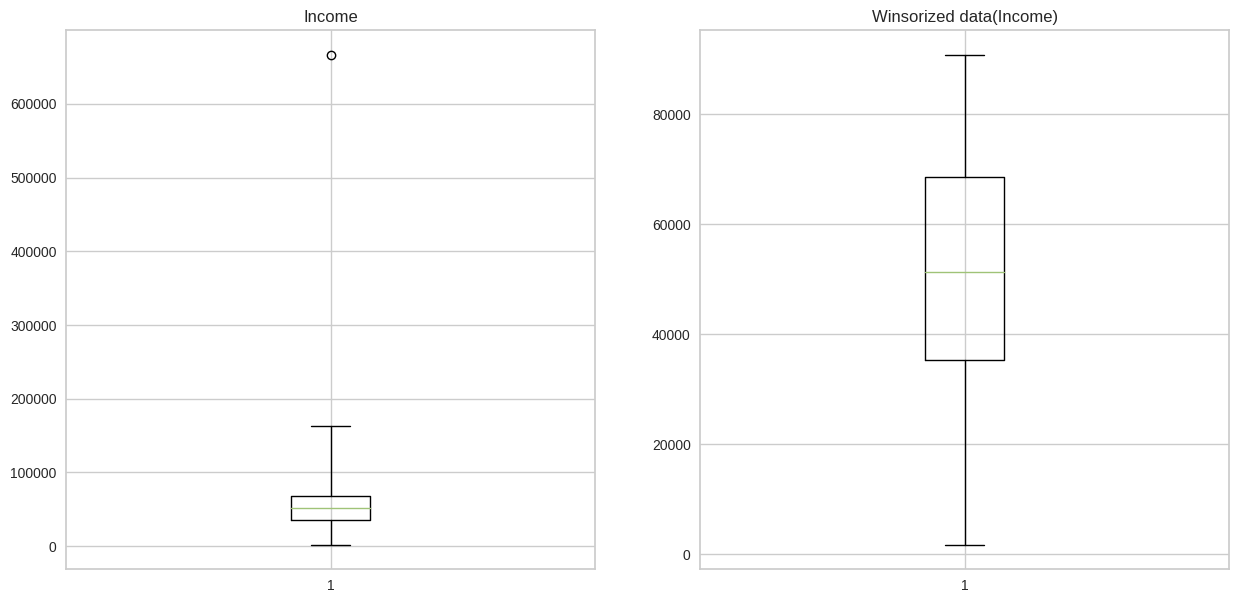

In [ ]:
plt.rcParams['figure.facecolor'] ="white"
df["Income_winsorized"] = winsorize(df["Income"], (0, 0.02))

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.title("Income")
plt.boxplot(df["Income"], whis=10)

plt.subplot(1,2,2)
plt.title("Winsorized data(Income)")
plt.boxplot(df["Income_winsorized"], whis=10)

In [ ]:
df["Total_spent"].describe()

count    2216.000000
mean      607.075361
std       602.900476
min         5.000000
25%        69.000000
50%       396.500000
75%      1048.000000
max      2525.000000
Name: Total_spent, dtype: float64

In [ ]:
df["Income"] = df["Income_winsorized"]
df = df.drop(["Income_winsorized"],axis=1)
df4=df.copy()


In [ ]:
df["Total_spent"].describe()

count    2216.000000
mean      607.075361
std       602.900476
min         5.000000
25%        69.000000
50%       396.500000
75%      1048.000000
max      2525.000000
Name: Total_spent, dtype: float64

In [ ]:
df.head()

Age     Education Marital_Status   Income  Recency  MntWines  MntFruits  \
0   66      Graduate         Single  58138.0       58       635         88   
1   69      Graduate         Single  46344.0       38        11          1   
2   58      Graduate        Partner  71613.0       26       426         49   
3   39      Graduate        Partner  26646.0       26        11          4   
4   42  Postgraduate        Partner  58293.0       94       173         43   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  AcceptedCmp2  \
0              546              172                88  ...             0   
1                6                2                 1  ...             0   
2              127              111                21  ...             0   
3               20               10                 3  ...             0   
4              118               46                27  ...             0   

   Complain  Response  Days_with_market  Total_spent  Total_Offer  \
0         0         1                92         1617            0   
1         0         0               938           27            0   
2         0         0               591          776            0   
3         0         0               998           53            0   
4         0         0               742          422            0   

   Num_Total_Purchases  Household_size  Is_parent  NumTotalPurchases  
0                   25               1          0                 25  
1                    6               3          1                  6  
2                   21               2          0                 21  
3                    8               3          1                  8  
4                   19               3          1                 19  

[5 rows x 30 columns]

In [ ]:
df["Total_spent"].describe()

count    2216.000000
mean      607.075361
std       602.900476
min         5.000000
25%        69.000000
50%       396.500000
75%      1048.000000
max      2525.000000
Name: Total_spent, dtype: float64

# 2. Exploratory data analysis

# 2.1 Distribution of all features

In [ ]:
plt.rcParams['figure.facecolor'] ="white"

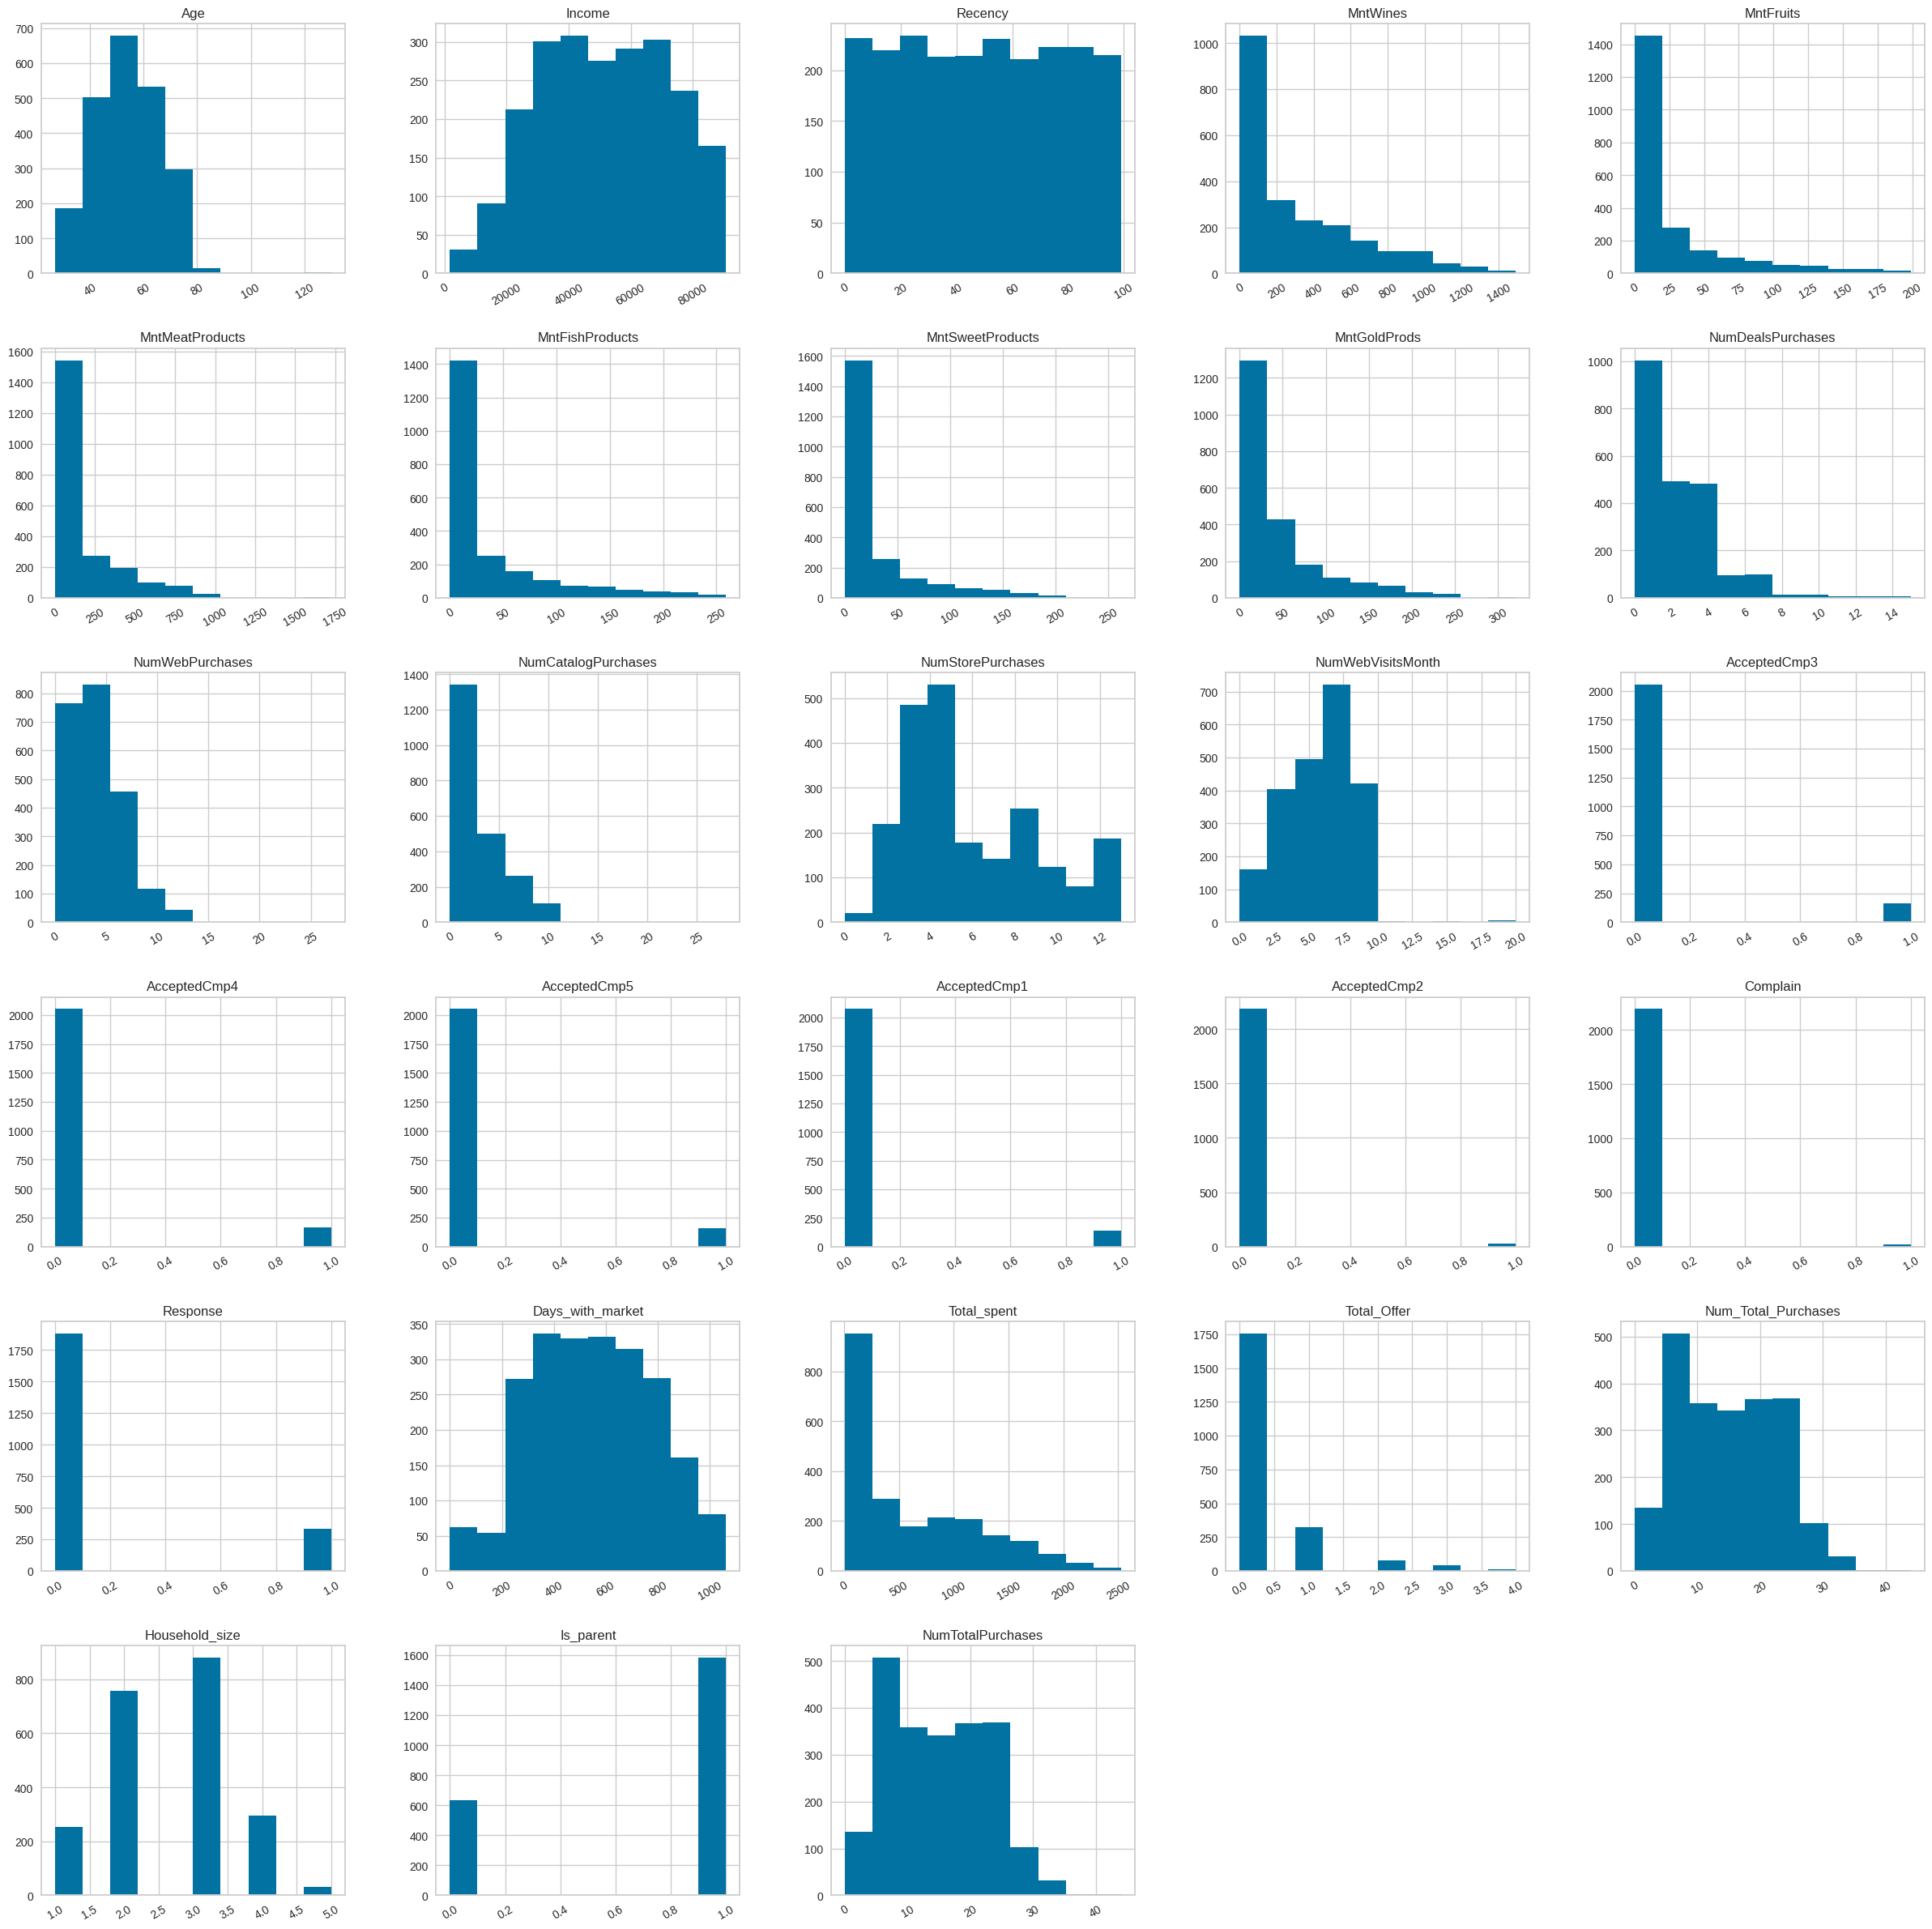

In [ ]:
df.hist(figsize=(30,30), xrot = 30) #Show all distributions of all the features in the dataset except
plt.show()

# 2.2 Correlation between two features considering is_parent feature

Text(0.5, 1.05, 'Feature Relationship')

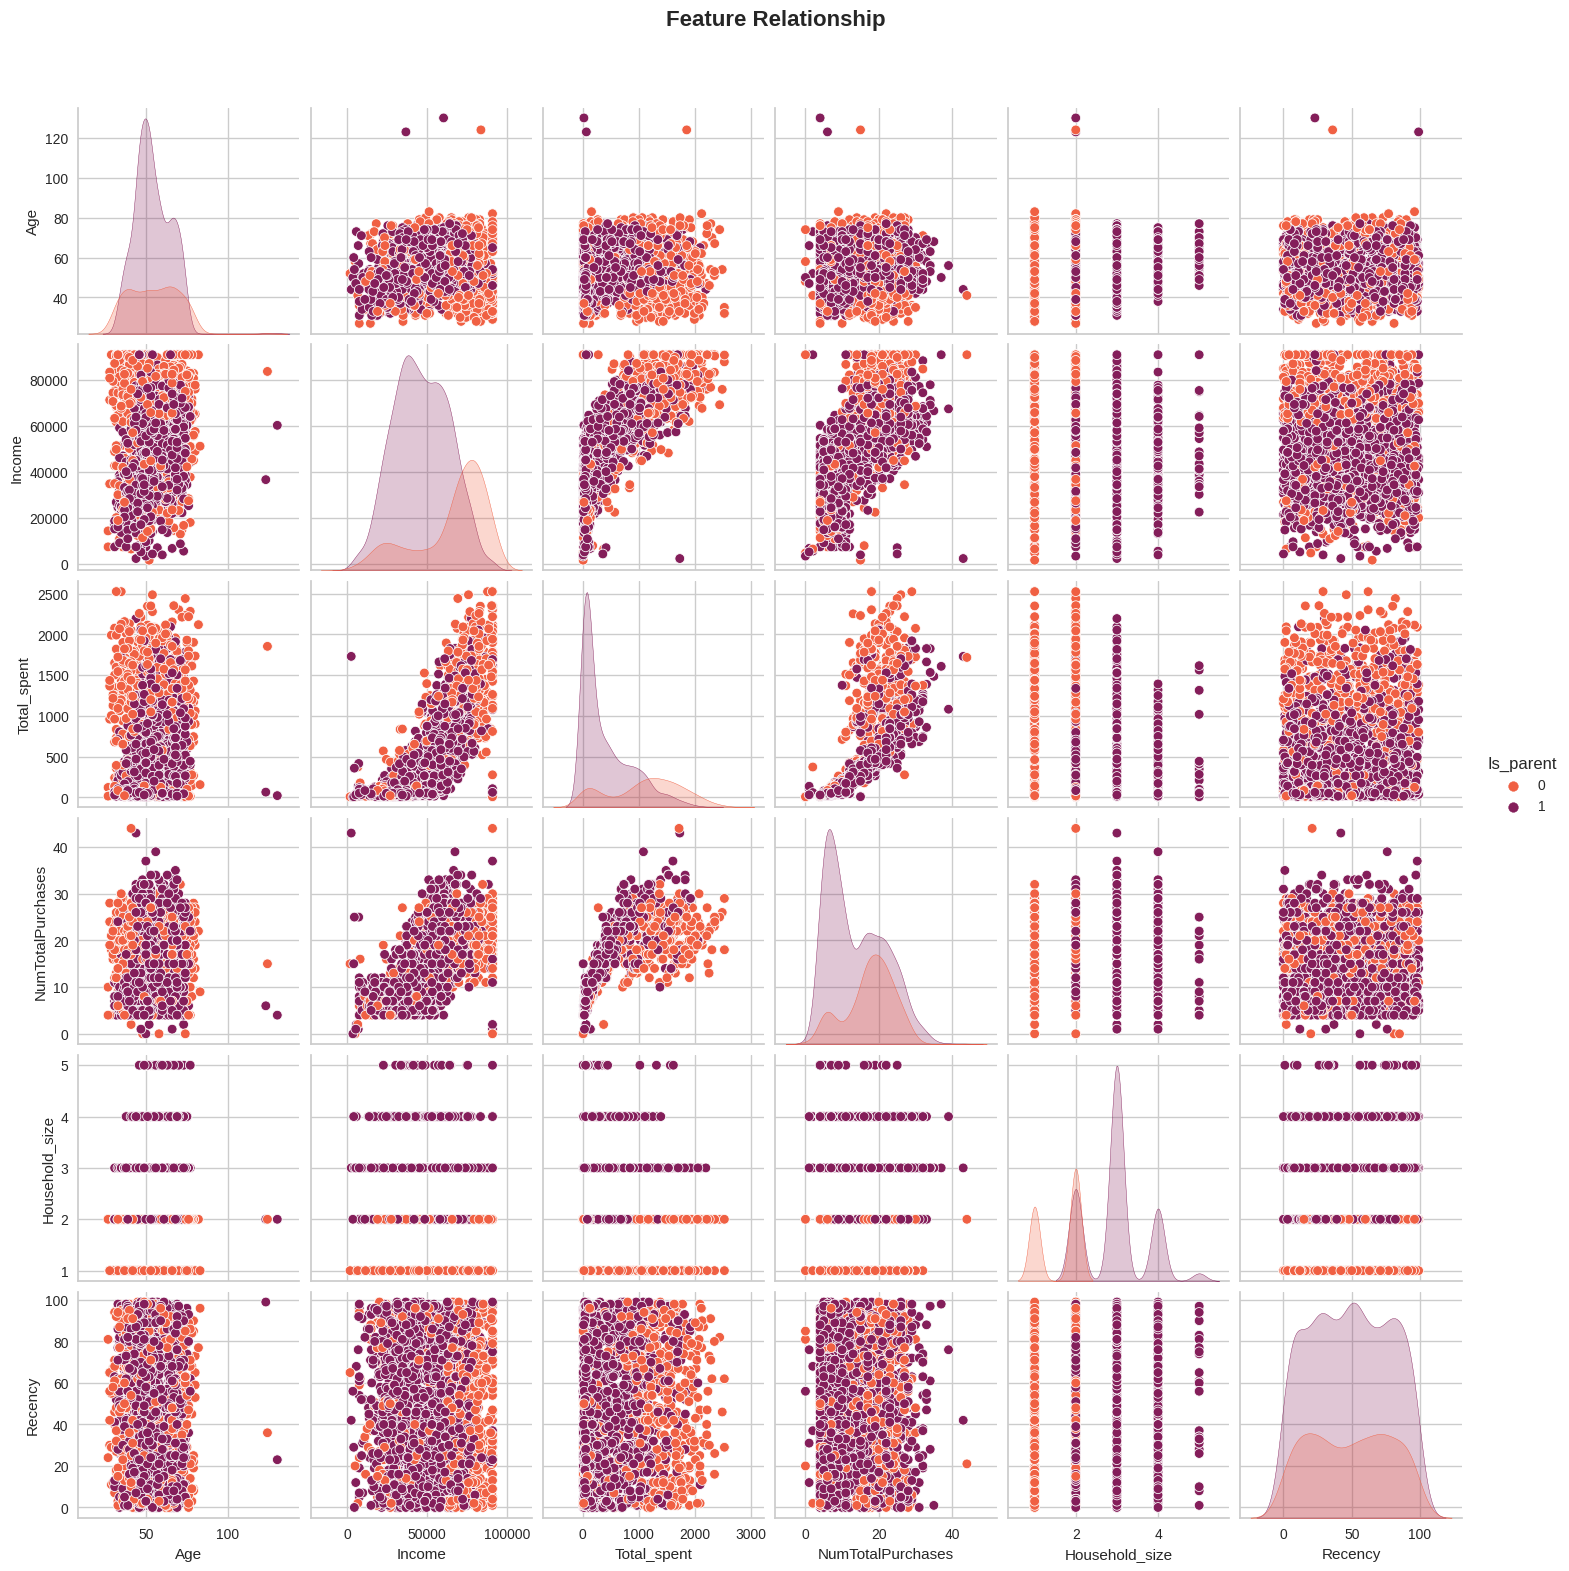

In [ ]:
sns.color_palette("rocket_r", as_cmap=True)

data = ['Age', 'Income', 'Total_spent','NumTotalPurchases','Household_size', 'Recency', 'Is_parent','Education']

plot = sns.pairplot(df[data], hue='Is_parent',palette="rocket_r")
plot.fig.suptitle('Feature Relationship', y=1.05, weight='bold', fontsize=16)

In [ ]:
df.columns

Index(['Age', 'Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Days_with_market',
       'Total_spent', 'Total_Offer', 'Num_Total_Purchases', 'Household_size',
       'Is_parent', 'NumTotalPurchases'],
      dtype='object')

Text(0.5, 1.05, 'Feature Relationship')

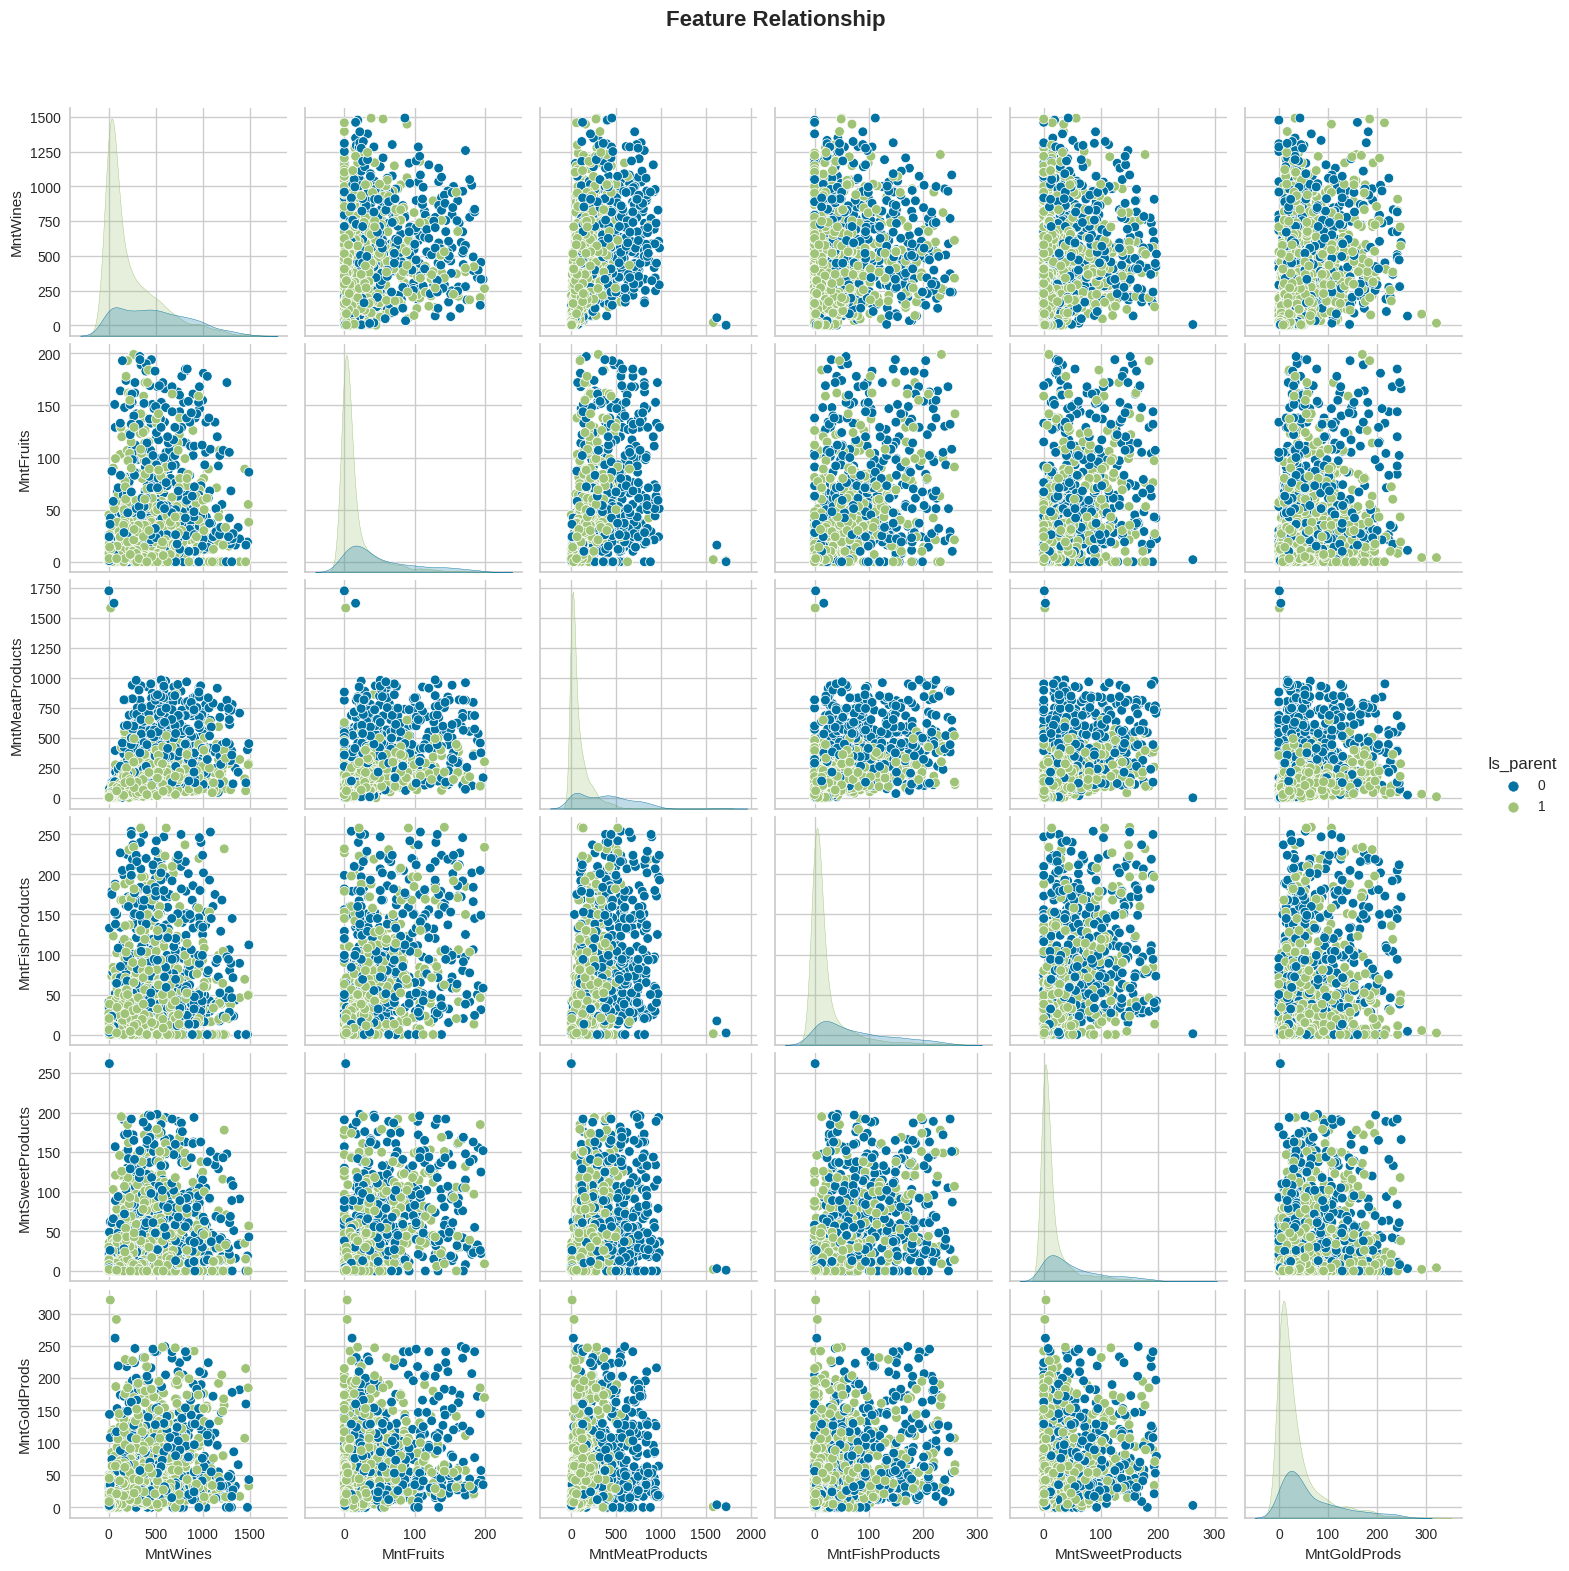

In [ ]:
sns.color_palette("BuGn_r", 10)
data = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds', 'Is_parent']

plot = sns.pairplot(df[data], hue='Is_parent' )
plot.fig.suptitle('Feature Relationship', y=1.05, weight='bold', fontsize=16)

# 2.3 Distribution of income

In [ ]:
import plotly.express as px
fig0 = px.histogram(df, x="Income", nbins=50)
fig0.show()

# 2.4 Distribution of education

In [ ]:
fig3 = px.histogram(df, x='Education', nbins=5, title="Education Level Distribution")
fig3.show()

# 2.5 Total_spent based on the education levels and being parent

In [ ]:
fig10 = px.histogram(df, x='Total_spent', color='Marital_Status', nbins=50,
                   title='Spending Distribution by Marital Status')
fig11 = px.histogram(df, x='Total_spent', color='Education', nbins=50,
                   title='Spending Distribution by Education Level')
fig12 = px.histogram(df, x='Total_spent', color='Is_parent', nbins=50,
                   title='Spending Distribution by Is_Parent')

fig10.show()
fig11.show()
fig12.show()

# 2.6 Total_spent based on age

In [ ]:
group = pd.cut(df['Age'], [10, 20, 30, 40, 50, 60, 70, 80])
group.value_counts()

(40, 50]    615
(50, 60]    613
(60, 70]    458
(30, 40]    283
(70, 80]    227
(20, 30]     15
(10, 20]      0
Name: Age, dtype: int64

<ipython-input-39-beba0d0d2db3>:10: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


<ipython-input-39-beba0d0d2db3>:19: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




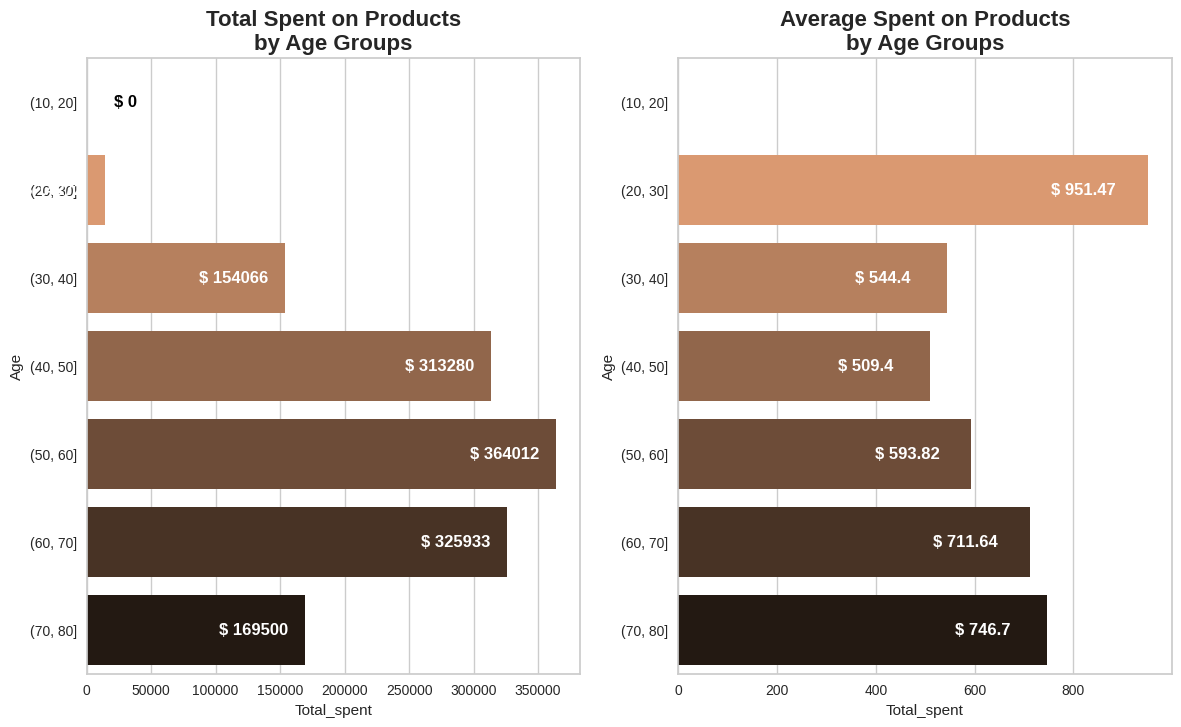

In [ ]:

df2 = df.copy()
df2['Age'] = group

sum_group = df2[['Total_spent', 'Age']].groupby('Age').sum()
mean_group = df2[['Total_spent', 'Age']].groupby('Age').mean()

fig, axes = plt.subplots(1,2,figsize=(14,8))
axes = axes.flatten()

sns.barplot(x=sum_group['Total_spent'], y=sum_group.index, palette='copper_r', ci=None, orient='h', ax=axes[0])
axes[0].set_title('Total Spent on Products\nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(sum_group['Total_spent']):
    if i == 0 or i ==7:
        axes[0].text(v+30000, i, '$ {}'.format(v), horizontalalignment='center', verticalalignment='center', weight='bold', color='black', fontsize=12)
    else:
        axes[0].text(v-40000, i, '$ {}'.format(v), horizontalalignment='center', verticalalignment='center', weight='bold', color='white', fontsize=12)

sns.barplot(x=mean_group['Total_spent'], y=mean_group.index, palette='copper_r', ci=None, orient='h', ax=axes[1])
axes[1].set_title('Average Spent on Products\nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(mean_group['Total_spent']):
    axes[1].text(v-130, i, '$ {}'.format(round(v,2)), horizontalalignment='center', verticalalignment='center', weight='bold', color='white', fontsize=12)

(0.0, 1.0, 0.0, 1.0)

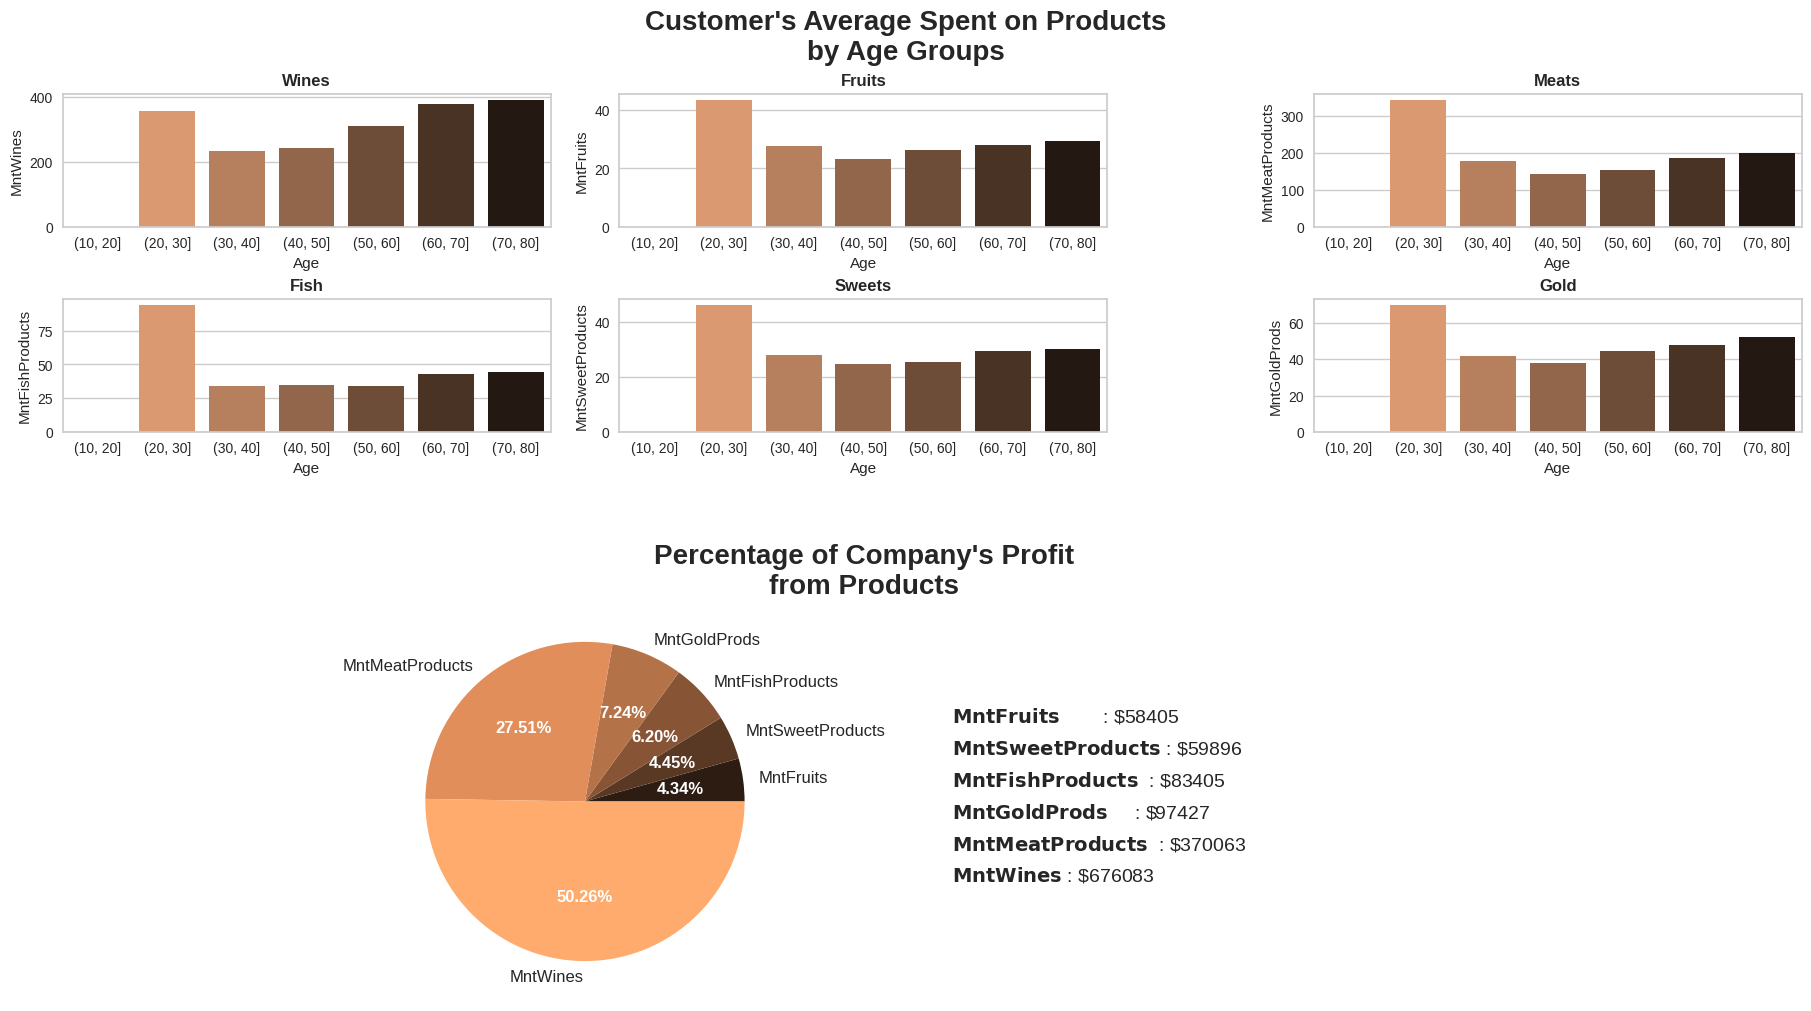

In [ ]:
fig, axd = plt.subplot_mosaic([[0,1,2],[3,4,5], [6,6,7], [6,6,7], [6,6,7]],
                              constrained_layout=True, figsize=(18,10))

fig.suptitle("Customer's Average Spent on Products\nby Age Groups", weight='bold', fontsize=20)

#Bar plot
sns.barplot(data=df, x=group, y='MntWines', palette='copper_r', errorbar=None, ax=axd[0])
axd[0].set_title('Wines', weight='bold')
sns.barplot(data=df, x=group, y='MntFruits', palette='copper_r', errorbar=None, ax=axd[1])
axd[1].set_title('Fruits', weight='bold')
sns.barplot(data=df, x=group, y='MntMeatProducts', palette='copper_r', errorbar=None, ax=axd[2])
axd[2].set_title('Meats', weight='bold')
sns.barplot(data=df, x=group, y='MntFishProducts', palette='copper_r', errorbar=None, ax=axd[3])
axd[3].set_title('Fish', weight='bold')
sns.barplot(data=df, x=group, y='MntSweetProducts', palette='copper_r', errorbar=None, ax=axd[4])
axd[4].set_title('Sweets', weight='bold')
sns.barplot(data=df, x=group, y='MntGoldProds', palette='copper_r', errorbar=None, ax=axd[5])
axd[5].set_title('Gold', weight='bold')

# Pie chart
data = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum().sort_values()

palette = sns.color_palette('copper')
wedges, texts, autotexts = axd[6].pie(x=data, labels=data.index, autopct='%.2f%%', colors=palette, textprops=dict(fontsize=12));
axd[6].set_title("\n\nPercentage of Company's Profit\nfrom Products", weight='bold', fontsize=20, x=1.2)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

# Text
for i, (name, value) in enumerate(zip(data.index, data)):
    axd[6].text(2.3, 0.5-0.2*i, r"$\bf{" + name + "}$" + "\t:" + " \$" + str(value), fontsize=14)

axd[7].axis('off')


In [ ]:
df.rename(columns={'NumWebPurchases':'Web', 'NumCatalogPurchases':'Catalog', 'NumStorePurchases':'Store'}, inplace=True)

(0.0, 1.0, 0.0, 1.0)

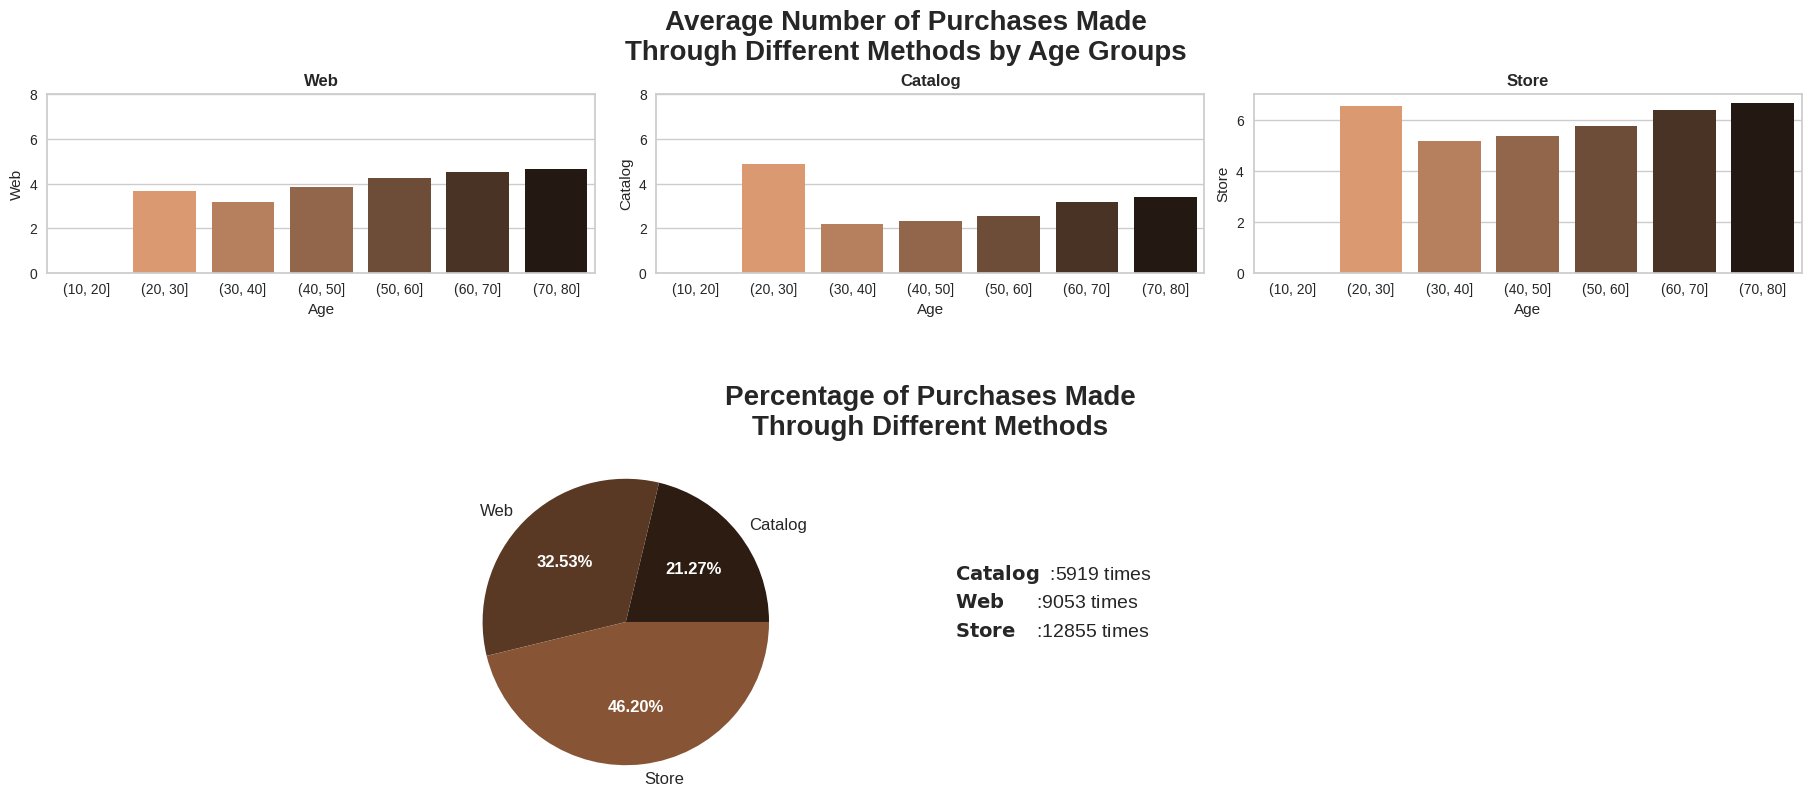

In [ ]:
fig, axd = plt.subplot_mosaic([[0,1,2], [3,3,4], [3,3,4]],
                               constrained_layout=True, figsize=(18,8))
fig.suptitle("Average Number of Purchases Made\nThrough Different Methods by Age Groups", weight='bold', fontsize=20)

custom_ylim = (0, 8)
plt.setp(axd[0], ylim=custom_ylim)
plt.setp(axd[1], ylim=custom_ylim)

# Bar plot
sns.barplot(data=df, x=group, y='Web', palette='copper_r', errorbar=None, ax=axd[0])
axd[0].set_title('Web', weight='bold')
sns.barplot(data=df, x=group, y='Catalog', palette='copper_r', errorbar=None, ax=axd[1])
axd[1].set_title('Catalog', weight='bold')
sns.barplot(data=df, x=group, y='Store', palette='copper_r', errorbar=None, ax=axd[2])
axd[2].set_title('Store', weight='bold')

# Pie chart
data = df[['Web', 'Catalog', 'Store']].sum().sort_values()

palette = sns.color_palette('copper')
wedges, texts, autotexts = axd[3].pie(x=data, labels=data.index, autopct='%.2f%%', colors=palette, textprops=dict(fontsize=12));
axd[3].set_title('\n\nPercentage of Purchases Made\nThrough Different Methods', weight='bold', fontsize=20, x=1.35)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

# Text
for i, (name, value) in enumerate(zip(data.index, data)):
    axd[3].text(2.3, 0.3-0.2*i, r"$\bf{" + name + "}$" + "\t:" + str(value) + " times", fontsize=14)

axd[4].axis('off')

# 2.7 Percentage of Customer Who Accepted the nth Offer

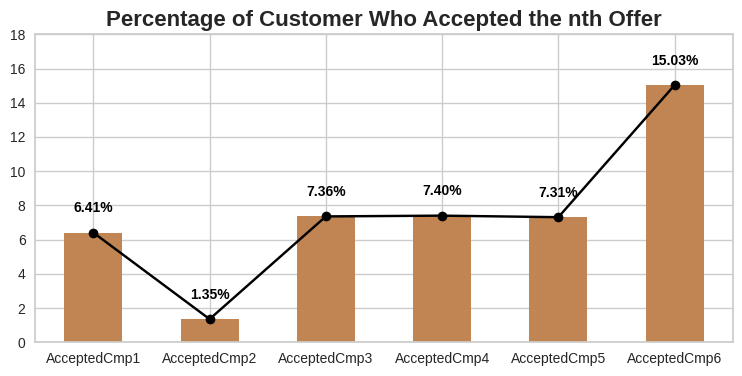

In [ ]:
df.rename(columns={'Response':'AcceptedCmp6'}, inplace=True)

plt.figure(figsize=(9,4))
plt.title('Percentage of Customer Who Accepted the nth Offer', weight='bold', fontsize=16)

percent = df.sum()[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp6']]*100/len(df)

ax = percent.plot.bar(color='#c08552')
percent.plot(style='o-', colormap='copper')

plt.setp(ax, ylim=(0, 18))

for i,v in enumerate(percent):
    plt.text(i, v+1.2, '{:.2f}%'.format(v), horizontalalignment='center', weight='bold', color='Black', fontsize=10)

# 2.8 Average Number of dealpurchases basedd on Age Groups and being parent

<Axes: title={'center': 'Average Number of Purchases Made with a Discount\nby Age Groups'}, xlabel='Age', ylabel='NumDealsPurchases'>

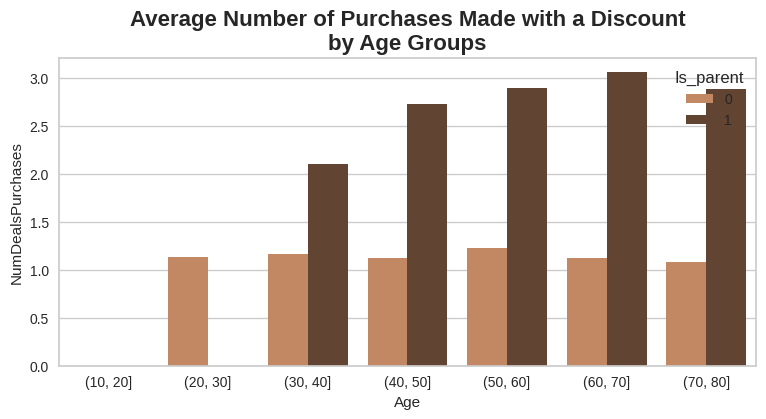

In [ ]:
plt.figure(figsize=(9,4))
plt.title('Average Number of Purchases Made with a Discount\nby Age Groups', weight='bold', fontsize=16)
sns.barplot(data=df, x=group, y='NumDealsPurchases', hue='Is_parent', errorbar=None, palette='copper_r')

# 2.9 Correlation between each pair of feature

<Axes: title={'center': 'Feature correlation'}>

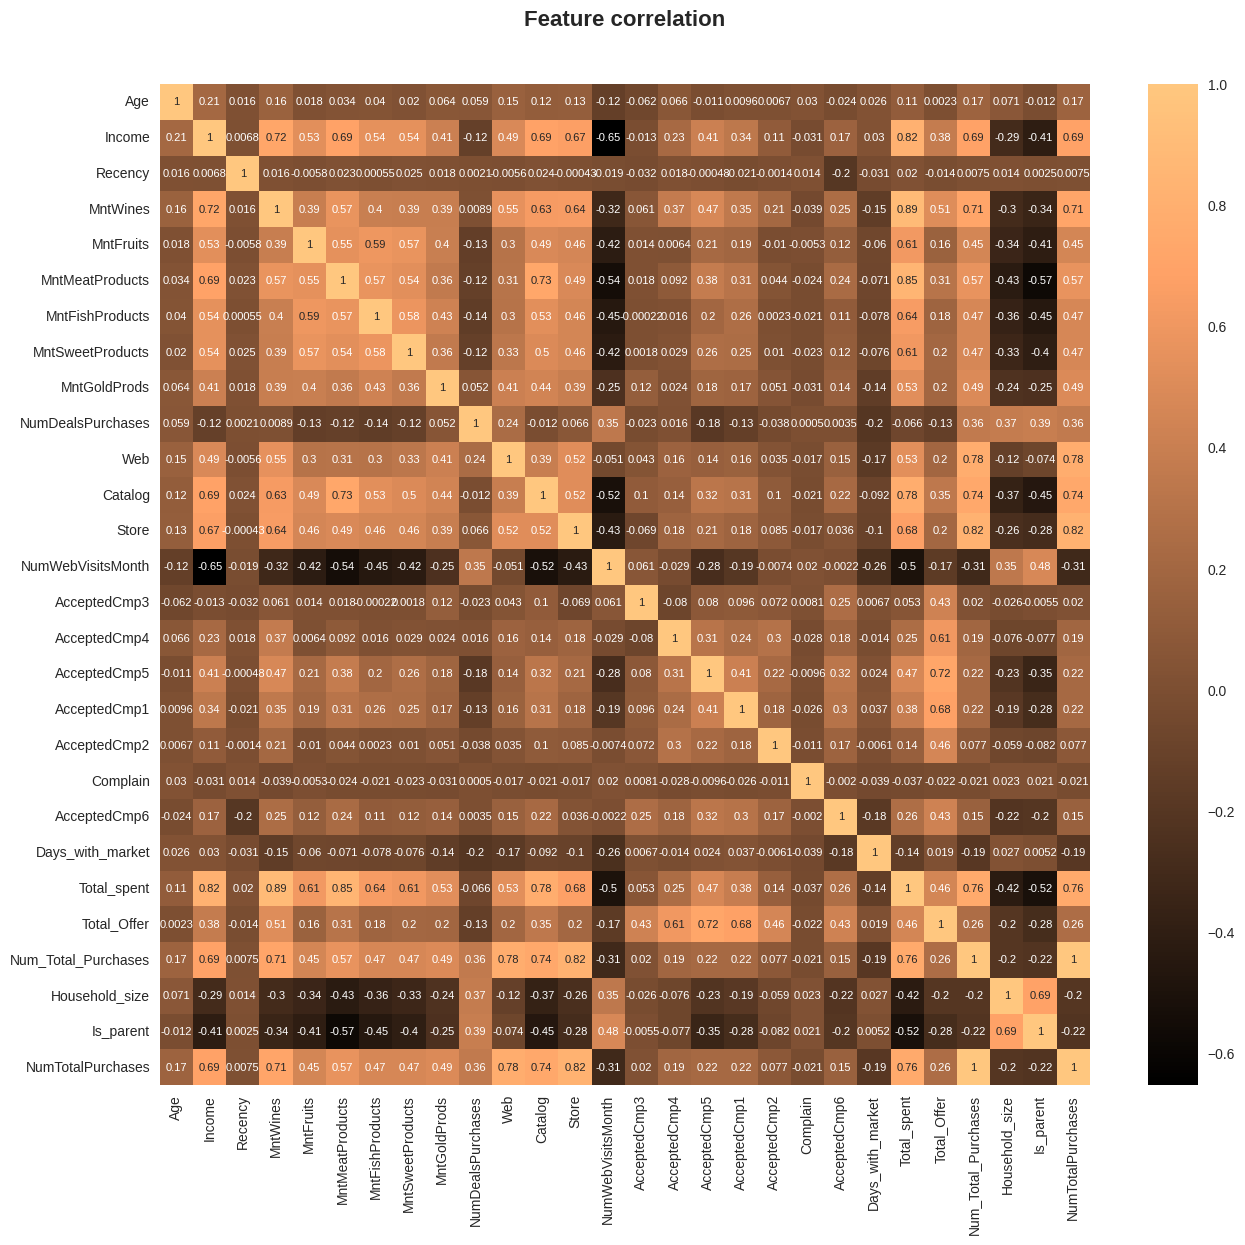

In [ ]:
data = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15,13))
plt.title('Feature correlation', weight='bold', fontsize=16, y=1.05)
sns.heatmap(df[data].corr(), cmap='copper',annot = True,annot_kws={"fontsize":8})

<ipython-input-46-7bf6785c514e>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

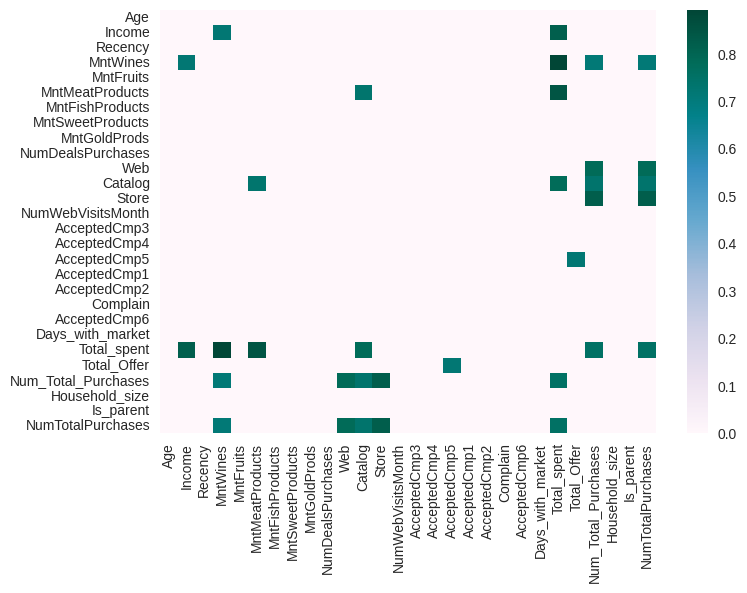

In [ ]:
corr_df = df.corr()
# All low correlations are replaced with 0
filter_low_correlations = (corr_df > -0.7) & (corr_df < 0.7)
corr_df[filter_low_correlations] = 0

# All correlations equal to 1 are replaced with 0
filter_ideal_correlations = (corr_df == 1.0)
corr_df[filter_ideal_correlations] = 0

fig = sns.heatmap(corr_df,cmap='PuBuGn')
fig

# 3. Data Preprocessing

# 3.1 converting features to numerical type and scaling:

In [ ]:
#converting categorical data types into numerical data types:
categorical_columns = (df.dtypes == 'object')
categorical_columns = list(categorical_columns[categorical_columns].index)
#print("Columns list with categorical data=", categorical_columns)
label_encoder = LabelEncoder() #convert values between o and 1
for i in categorical_columns:
    df[i] = df[[i]].apply(label_encoder.fit_transform)
df.head()

Age  Education  Marital_Status   Income  Recency  MntWines  MntFruits  \
0   66          0               2  58138.0       58       635         88   
1   69          0               2  46344.0       38        11          1   
2   58          0               1  71613.0       26       426         49   
3   39          0               1  26646.0       26        11          4   
4   42          1               1  58293.0       94       173         43   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  AcceptedCmp2  \
0              546              172                88  ...             0   
1                6                2                 1  ...             0   
2              127              111                21  ...             0   
3               20               10                 3  ...             0   
4              118               46                27  ...             0   

   Complain  AcceptedCmp6  Days_with_market  Total_spent  Total_Offer  \
0         0             1                92         1617            0   
1         0             0               938           27            0   
2         0             0               591          776            0   
3         0             0               998           53            0   
4         0             0               742          422            0   

   Num_Total_Purchases  Household_size  Is_parent  NumTotalPurchases  
0                   25               1          0                 25  
1                    6               3          1                  6  
2                   21               2          0                 21  
3                    8               3          1                  8  
4                   19               3          1                 19  

[5 rows x 30 columns]

In [ ]:
# #data scaling:
# scaler = MinMaxScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# df.head()

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler_robust = RobustScaler()
df = pd.DataFrame(scaler_robust.fit_transform(df), columns=df.columns)
df.head()

Age  Education  Marital_Status    Income  Recency  MntWines  \
0  0.722222        0.0             1.0  0.203393     0.18  0.957380   
1  0.888889        0.0             1.0 -0.151645    -0.22 -0.339917   
2  0.277778        0.0             0.0  0.609034    -0.46  0.522869   
3 -0.777778        0.0             0.0 -0.744619    -0.46 -0.339917   
4 -0.611111        1.0             0.0  0.208059     0.90 -0.003119   

   MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  ...  \
0   2.580645         2.210405         3.404255           2.50000  ...   
1  -0.225806        -0.286705        -0.212766          -0.21875  ...   
2   1.322581         0.272832         2.106383           0.40625  ...   
3  -0.129032        -0.221965        -0.042553          -0.15625  ...   
4   1.129032         0.231214         0.723404           0.59375  ...   

   AcceptedCmp2  Complain  AcceptedCmp6  Days_with_market  Total_spent  \
0           0.0       0.0           1.0         -1.323699     1.246680   
1           0.0       0.0           0.0          1.121387    -0.377426   
2           0.0       0.0           0.0          0.118497     0.387640   
3           0.0       0.0           0.0          1.294798    -0.350868   
4           0.0       0.0           0.0          0.554913     0.026047   

   Total_Offer  Num_Total_Purchases  Household_size  Is_parent  \
0          0.0             0.769231            -2.0       -1.0   
1          0.0            -0.692308             0.0        0.0   
2          0.0             0.461538            -1.0       -1.0   
3          0.0            -0.538462             0.0        0.0   
4          0.0             0.307692             0.0        0.0   

   NumTotalPurchases  
0           0.769231  
1          -0.692308  
2           0.461538  
3          -0.538462  
4           0.307692  

[5 rows x 30 columns]

# 3.2 Dimension Reduction using PCA:

In [ ]:
# #Check the Co-relation between features without PCA
# # a
# #we should check correlation between colmns to find best value for dimention reductiuon
# sns.heatmap(df.corr())

In [ ]:
pca = PCA(n_components=3)
pca.fit(df)
df_pca = pd.DataFrame(pca.transform(df), columns=(['PC1','PC2','PC3']))
df_pca.head()

PC1       PC2       PC3
0  4.934256  0.050462  0.611307
1 -2.364774 -0.773860 -0.030073
2  1.559347 -0.317009  0.058229
3 -2.324639 -0.751934  0.343269
4 -0.086793  0.825974  0.921009

In [ ]:
#without PCA
#df_pca = df
#df_pca.head()

# 3.3 Checking Co-relation between features after PCA

<Axes: title={'center': 'Feature correlation'}>

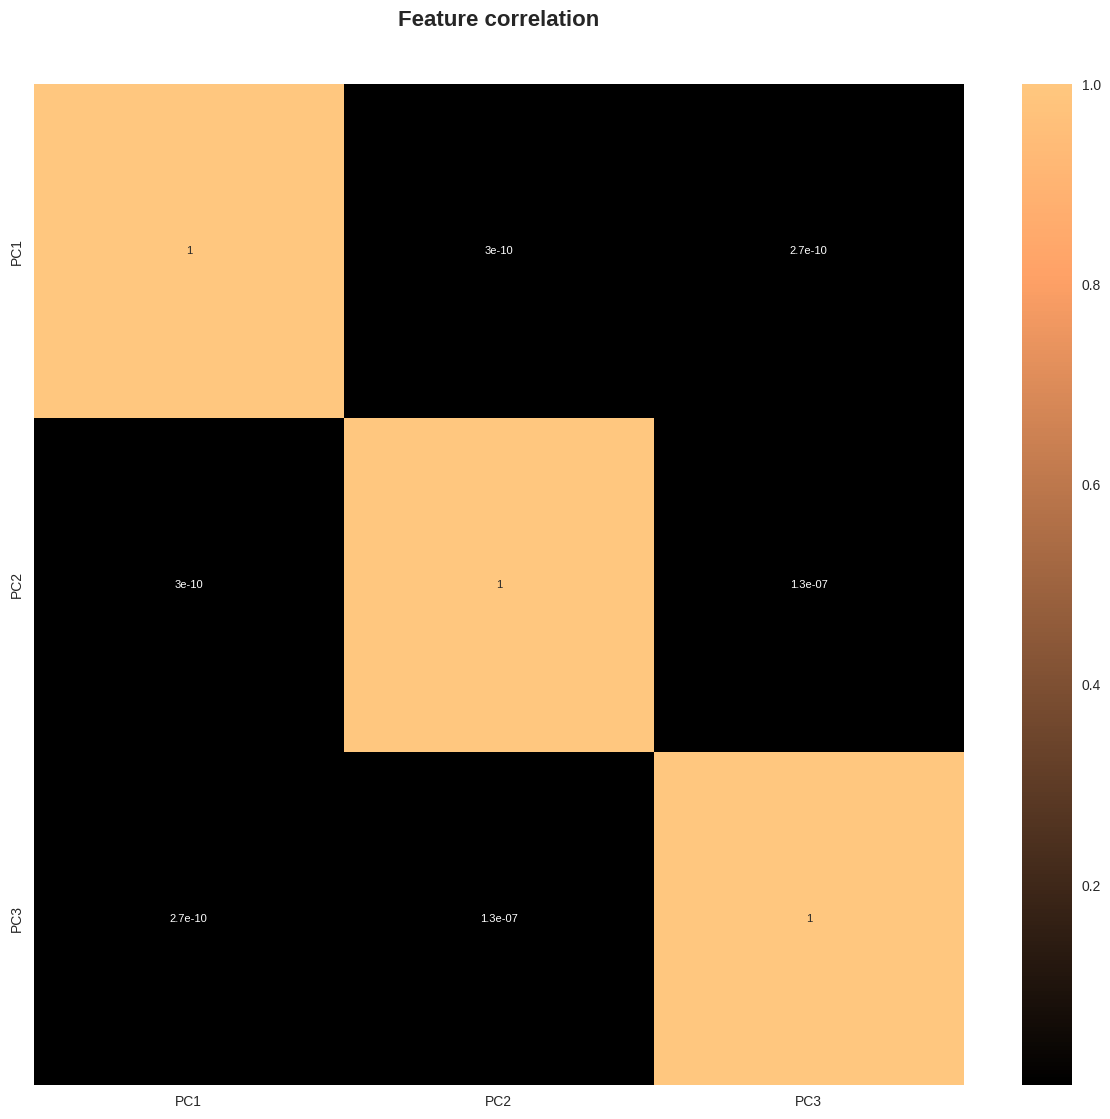

In [ ]:
#Checking Co-relation between features after PCA
data = df_pca.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15,13))
plt.title('Feature correlation', weight='bold', fontsize=16, y=1.05)
sns.heatmap(df_pca[data].corr(), cmap='copper',annot = True,annot_kws={"fontsize":8})

# 4. Clustering data using different type of algorithms


# 4.1 Finding the number of clusters using elbow method and silhouette score

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

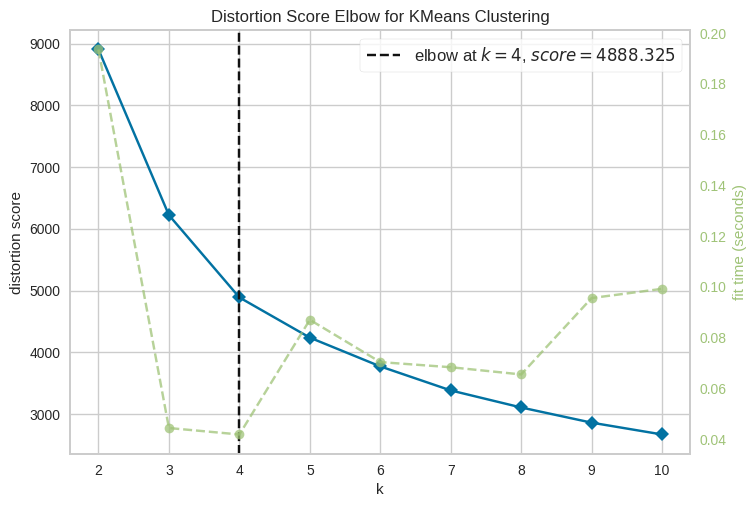

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Finding the number of clusters to be formed using elbow method

elbow_chart = KElbowVisualizer(KMeans(), k=10)
elbow_chart.fit(df_pca)
elbow_chart.show()

 For 2 clusters, SilhoutteScore is: 0.5140969118021383
 For 3 clusters, SilhoutteScore is: 0.4449359269161933
 For 4 clusters, SilhoutteScore is: 0.43022679180477225
 For 5 clusters, SilhoutteScore is: 0.4296718116734964
 For 6 clusters, SilhoutteScore is: 0.4176893061081567
 For 7 clusters, SilhoutteScore is: 0.35109392545146606
 For 8 clusters, SilhoutteScore is: 0.33771167950027003
 For 9 clusters, SilhoutteScore is: 0.299843806044813
 For 10 clusters, SilhoutteScore is: 0.29443123063792975


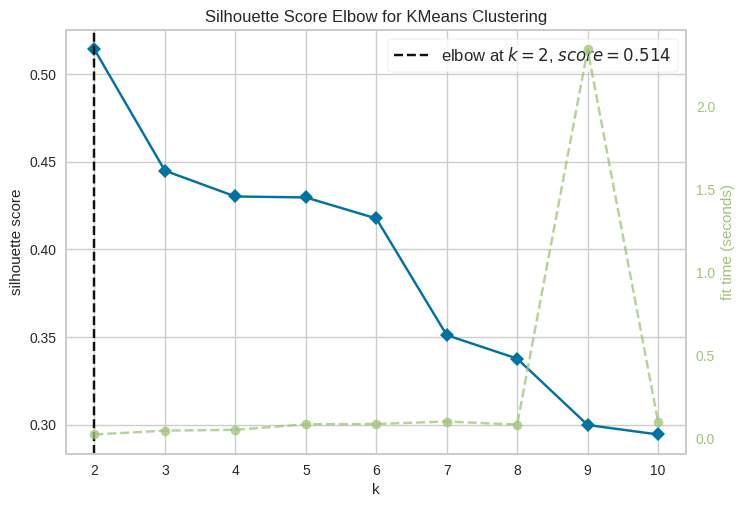

In [ ]:
from sklearn.metrics import silhouette_score
def silhoutte(dataframe, l_range, h_range):
    for i in range(l_range, h_range):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=100, random_state=0
        )
        km.fit(dataframe)
        cluster_labels = km.labels_

        silhouette_avg = silhouette_score(dataframe, cluster_labels)
        print(f" For {i} clusters, SilhoutteScore is: {silhouette_avg}")


#Silhoutte Score method using Yellwbrick library
def silhoutte_auto(dataframe, l_range, h_range):
    model = KMeans(init='k-means++',n_init=10, max_iter=100, random_state=0)
    visualizer = KElbowVisualizer(model, k=(l_range,h_range), metric='silhouette')

    visualizer.fit(dataframe)
    visualizer.show()
    plt.show()


silhoutte(df_pca, 2, 11)
silhoutte_auto(df_pca, 2, 11)


# 4.3 Agglomerative clustering model

In [ ]:
# Getting 4 clusters from above, now fitting the agglomerative clustering model to get the clusters
# intialize the model (agglomerative)
agglomerative_clustering = AgglomerativeClustering(n_clusters=4,linkage="ward")
# fit the model to predict clusters
clusters_AC = agglomerative_clustering.fit_predict(df_pca)
# adding the clusters to original Dataset

df["Clusters_hi"] = clusters_AC
sc= silhouette_score(df_pca, clusters_AC)
print (f"Silhoutte Score is: {sc}")
# df_pca["Clusters"]

Silhoutte Score is: 0.4117087832218122


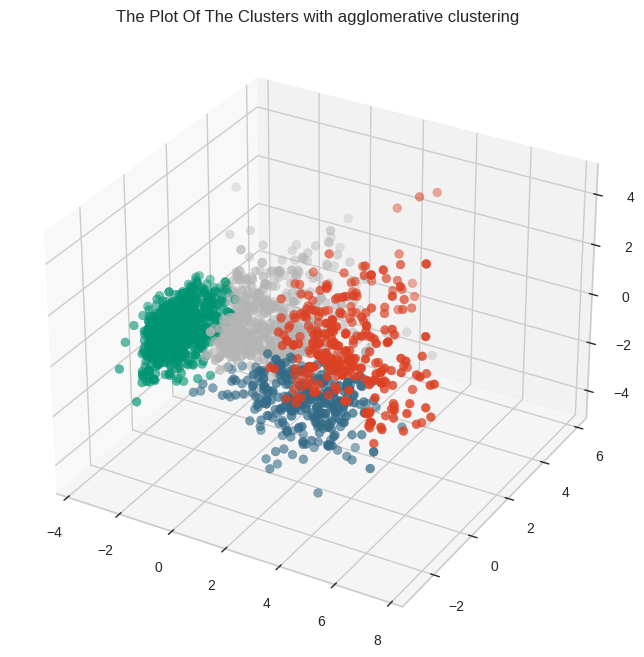

In [ ]:
# Plotting the clusters
x = df_pca['PC1']
y = df_pca['PC2']
z = df_pca['PC3']
figure = plt.figure(figsize=(10,8))
new_x = plt.subplot(111, projection='3d', label="bla")
colors1 = ['#b4b4b4', '#dd4124', '#009473', '#336b87']

cmap = colors.ListedColormap(colors1)
new_x.scatter(x, y, z, s=40, c=df["Clusters_hi"], marker='o', cmap = cmap )
new_x.set_title("The Plot Of The Clusters with agglomerative clustering")
plt.show()

# 4.4 K-means clustering model


In [ ]:
kmeans_clustering = KMeans(n_clusters=4)
# fit the model to predict clusters
clusters_KM = kmeans_clustering.fit_predict(df_pca)
df["Clusters_KMeans"] = clusters_KM
df4["Clusters_KMeans"] = clusters_KM

# adding the clusters to original Dataset

sc= silhouette_score(df_pca, clusters_KM)
print (f"Silhoutte Score is: {sc}")
# df_pca["Clusters"]
# df_pca["Clusters_KMeans"]

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhoutte Score is: 0.4304386171413084


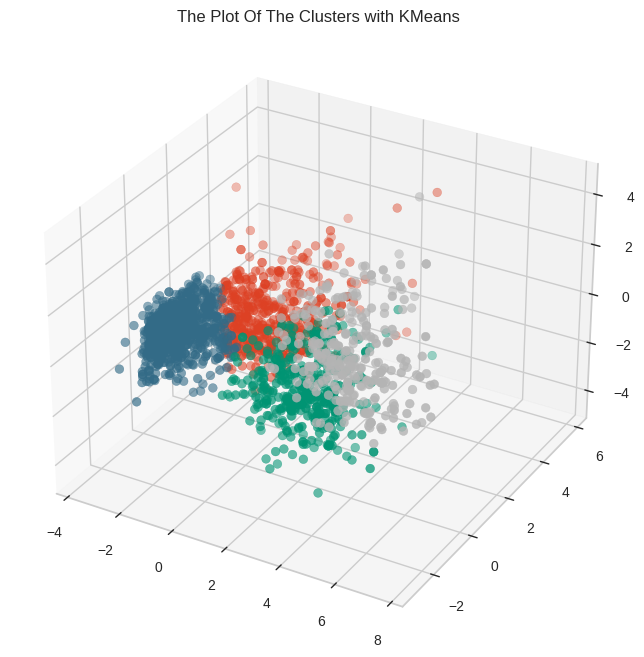

In [ ]:
figure = plt.figure(figsize=(10,8))
new_x = plt.subplot(111, projection='3d', label="bla")
new_x.scatter(x, y, z, s=40, c=df["Clusters_KMeans"], marker='o', cmap = cmap )
new_x.set_title("The Plot Of The Clusters with KMeans")
plt.show()

# 4.5 DBScan clustering model


In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

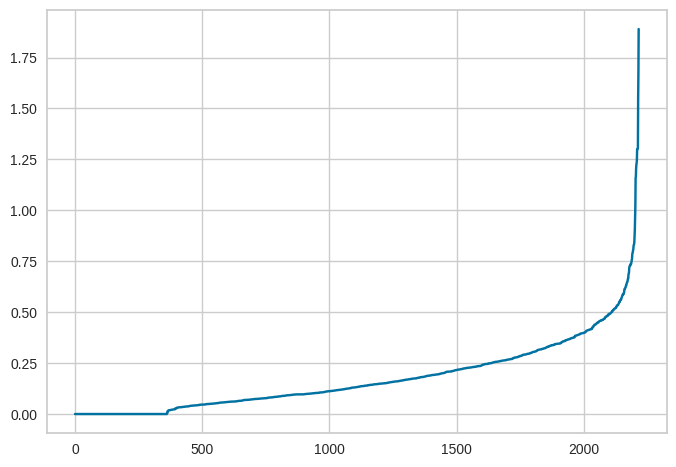

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
from sklearn.cluster import DBSCAN
min_samples = range(4,7)
eps = np.arange(0.4,1.5, 0.1)
output = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(df_pca).labels_
        score = silhouette_score(df_pca, labels)
        output.append((ms, ep, score))
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")
# outlier_percent=[]
# for e in np.linspace(0.5,1,100):
#     dbmodel=DBSCAN(eps=e,min_samples=df_pca.shape[1]*2)
#     dbmodel.fit(df_pca)
#     perc_outliers = 100 * np.sum(dbmodel.labels_ == -1) / len(dbmodel.labels_)
#     outlier_percent.append(perc_outliers)

Best silhouette_score: 0.45550996838698476
min_samples: 6
eps: 1.4


In [ ]:
# plt.figure(figsize=(6,5))
# sns.scatterplot(x= np.lins/pace(0.5,1,100),y=outlier_percent)


In [ ]:
DBSCAN_clustering = DBSCAN(eps=1.29, min_samples=6)
# fit the model to predict clusters
clusters_db = DBSCAN_clustering.fit_predict(df_pca)
df["Clusters_DBSCAN"] = clusters_db
# adding the clusters to original Dataset
clusters_db

array([0, 0, 0, ..., 0, 0, 0])

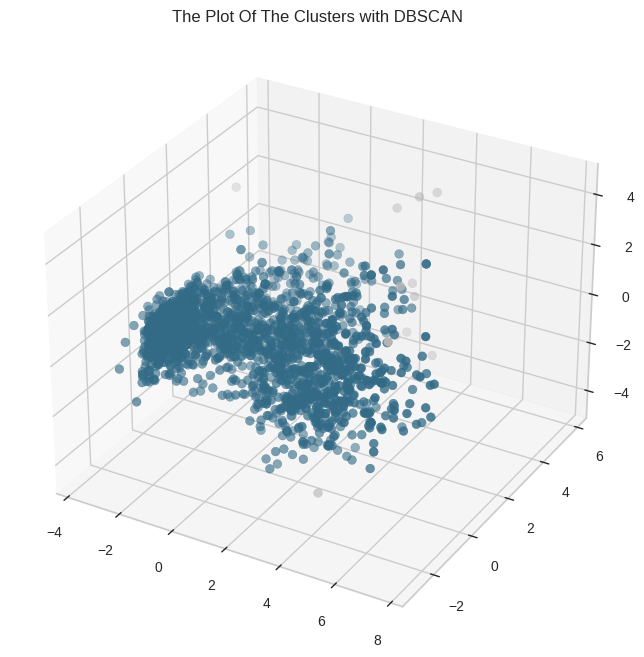

In [ ]:
figure = plt.figure(figsize=(10,8))
new_x = plt.subplot(111, projection='3d', label="bla")
new_x.scatter(x, y, z, s=40, c=clusters_db, marker='o', cmap = cmap )
new_x.set_title("The Plot Of The Clusters with DBSCAN")
plt.show()


# 4.6 OPTICS clustering model

In [ ]:
from sklearn.cluster import OPTICS
OP = OPTICS(eps=0.54, min_samples=6)
# fit model and predict clusters
OP_df = OP.fit_predict(df_pca)
#Adding the Clusters feature to the orignal dataframe.
df["Clusters_optics"]= OP_df

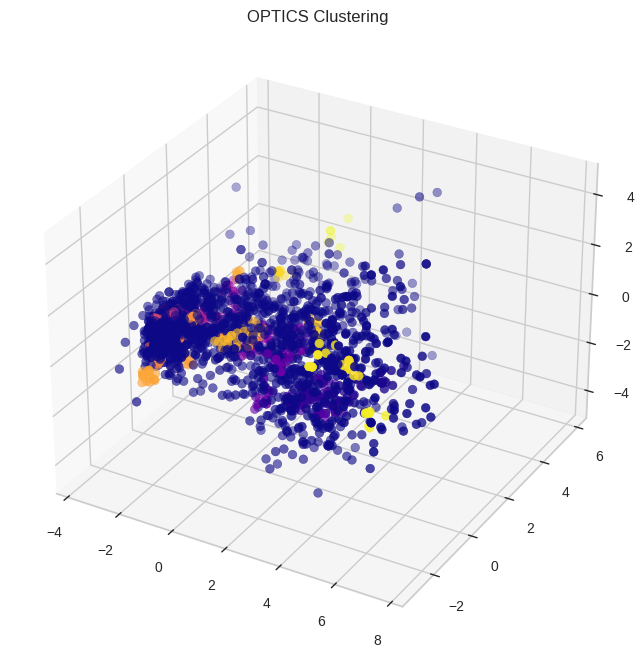

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c= OP_df, marker='o', cmap = 'plasma' )
ax.legend()
ax.set_title("OPTICS Clustering")
plt.show()

In [ ]:
df.columns

Index(['Age', 'Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'Web', 'Catalog', 'Store',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'AcceptedCmp6',
       'Days_with_market', 'Total_spent', 'Total_Offer', 'Num_Total_Purchases',
       'Household_size', 'Is_parent', 'NumTotalPurchases', 'Clusters_hi',
       'Clusters_KMeans', 'Clusters_DBSCAN', 'Clusters_optics'],
      dtype='object')

# 4.7 Gaussian Mixture clustering model

In [ ]:
data_clustring=df_pca[['PC1', 'PC2', 'PC3']].copy()
# for i in data_clustring.columns:
#     data_clustring[i]=MinMaxScaler().fit_transform(np.array(data_clustring[[i]]))
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 4, covariance_type = 'spherical', max_iter = 3000, random_state = 228).fit(df_pca)
labels = gmm.predict(df_pca)

df['Cluster_gaussian'] = labels
data_re_clust = {
    0: 'Beneficial  client',
    1: 'Ordinary client',
    2: 'loyal client without high benefit',
    3: 'Potential good client'
}
df['Cluster_gaussian'] = df['Cluster_gaussian'].map(data_re_clust)
df4['Cluster_gaussian'] = df['Cluster_gaussian']


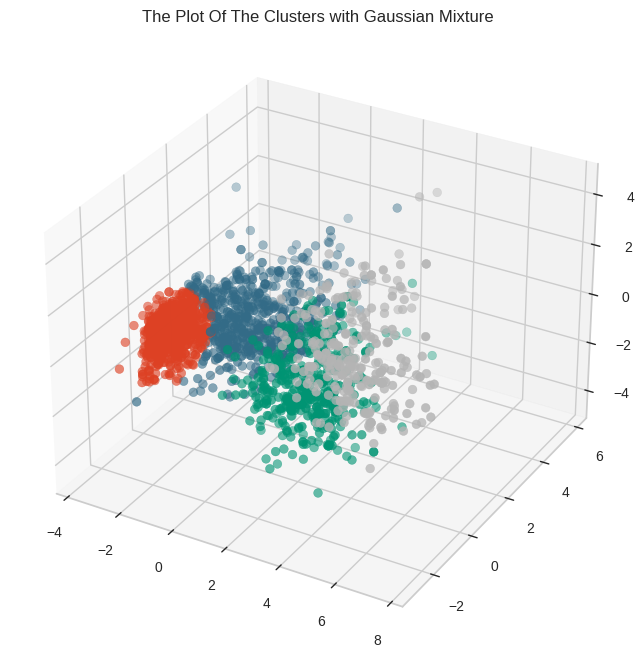

In [ ]:
figure = plt.figure(figsize=(10,8))
new_x = plt.subplot(111, projection='3d', label="bla")
new_x.scatter(x, y, z, s=40, c=labels, marker='o', cmap = cmap )
new_x.set_title("The Plot Of The Clusters with Gaussian Mixture")
plt.show()

In [ ]:
sc= silhouette_score(df_pca, labels)
print (f"Silhoutte Score is: {sc}")


Silhoutte Score is: 0.3946821556062364


In [ ]:
import plotly.express as px
fig = px.pie(df['Cluster_gaussian'].value_counts().reset_index(), values = 'Cluster_gaussian', names = 'index', width = 700, height = 700)
fig.update_traces(textposition = 'inside',
                  textinfo = 'percent + label',
                  hole = 0.8,
                  marker = dict(colors = ['#dd4124','#009473', '#336b87', '#b4b4b4'], line = dict(color = 'white', width = 2)),
                  hovertemplate = 'Clients: %{value}')

fig.update_layout(annotations = [dict(text = 'Number of clients <br>by cluster',
                                      x = 0.5, y = 0.5, font_size = 28, showarrow = False,
                                      font_family = 'monospace',
                                      font_color = 'black')],
                  showlegend = False)

fig.show()

6. Evaluation

In [ ]:
df4['Cluster_KM'] = clusters_KM
data_re_clust = {
    1: 'Beneficial client',
    2: 'low income - low spent client',
    3: 'Ordinary',
    0: 'Potential good client'
}
df4['Cluster_KM'] = df4['Cluster_KM'].map(data_re_clust)

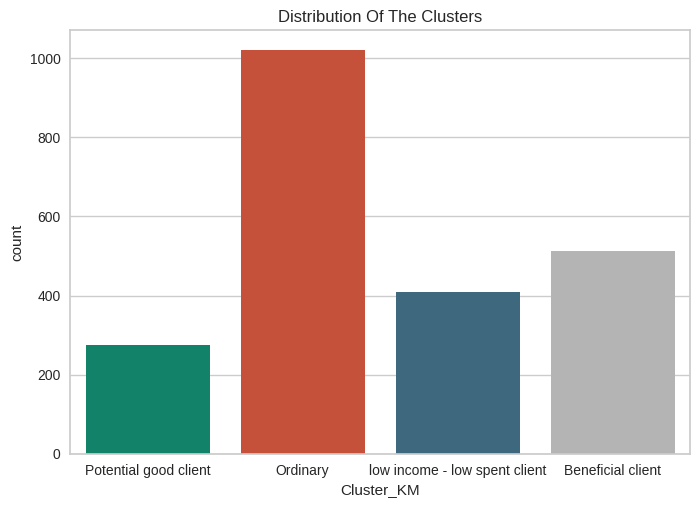

In [ ]:
# first step - Group distribution of clustering:
palette = ['#009473', '#dd4124', '#336b87','#b4b4b4',]
plot_clusters = sns.countplot(x=df4["Cluster_KM"], palette= palette)
plot_clusters.set_title("Distribution Of The Clusters")
plt.show()
# cluster looks fairly distributed

In [ ]:
# palette =['#b4b4b4', '#dd4124', '#009473', '#336b87']

# plot_clusters = sns.countplot(x=df["Cluster_KM"], palette= palette)
# plot_clusters.set_title("Distribution Of The Clusters by K-Means Clustering")
# plt.show()
# # cluster looks fairly distributed

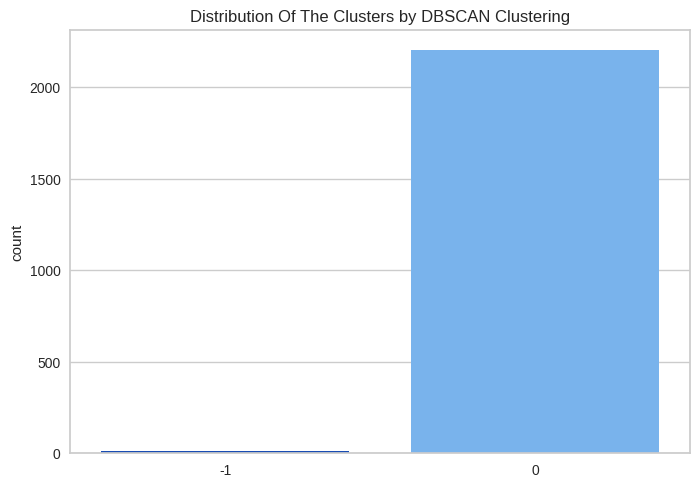

In [ ]:
palette = ["#0044cc", "#66b3ff", "#ff884d", "#ff6699",  "#ff6679"]
plot_clusters = sns.countplot(x=clusters_db, palette= palette)
plot_clusters.set_title("Distribution Of The Clusters by DBSCAN Clustering")
plt.show()
# cluster looks fairly distributed

# 5. Customer Segment Analysis

# 5.1 Customer Segment Analysis based on Gaussian clustering

In [ ]:
import plotly.graph_objs as go
plot = go.Figure()
df_pca["Cluster_gaussian"] = df["Cluster_gaussian"]
colors1 = ['#b4b4b4', '#dd4124', '#009473', '#336b87']
names = ['Beneficial  client','Ordinary client','loyal client without high benefit','Potential good client']
for i in range(4):
    cl = names[i]
    plot.add_trace(go.Scatter3d(x= df_pca.query("Cluster_gaussian == @cl")['PC1'],
                                y = df_pca.query("Cluster_gaussian == @cl")['PC2'],
                                z = df_pca.query("Cluster_gaussian == @cl")['PC3'],
                                mode = 'markers',
                                name = names[i],
                                marker = dict(
                                    size = 2,
                                    color = colors1[i],
                                    opacity = 0.6)))

plot.update_traces(hovertemplate = 'Total_spent: %{x} <br>Income Check: %{y} <br>Days is client: %{z}')

plot.update_layout(width = 800, height = 800, autosize = True, showlegend = False,
                   scene = dict(xaxis = dict(title = 'PC1', titlefont_color = 'black'),
                                yaxis = dict(title = 'PC2', titlefont_color = 'black'),
                                zaxis = dict(title = 'PC3', titlefont_color = 'black')),
                   font = dict(family = "monospace", color  = 'black', size = 12),
                   title_text = 'Customers clusters', title_x = 0.5)

# 5.2 Customer Segment Analysis based on the number of deal purchases

In [ ]:
df.columns

Index(['Age', 'Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'Web', 'Catalog', 'Store',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'AcceptedCmp6',
       'Days_with_market', 'Total_spent', 'Total_Offer', 'Num_Total_Purchases',
       'Household_size', 'Is_parent', 'NumTotalPurchases', 'Clusters_hi',
       'Clusters_KMeans', 'Clusters_DBSCAN', 'Clusters_optics',
       'Cluster_gaussian'],
      dtype='object')

In [ ]:
df4["Clusters_hi"] =clusters_AC

In [ ]:
df4.groupby(['Clusters_hi']).agg({'Complain': 'sum'})

Complain
Clusters_hi          
0                   3
1                   3
2                  12
3                   3

In [ ]:
df4.groupby(['Cluster_KM']).agg({'Complain': 'sum'})

Complain
Cluster_KM                             
Beneficial client                     3
Ordinary                             12
Potential good client                 3
low income - low spent client         3

In [ ]:
df4.groupby(['Cluster_KM']).size()

Cluster_KM
Beneficial client                 513
Ordinary                         1020
Potential good client             275
low income - low spent client     408
dtype: int64

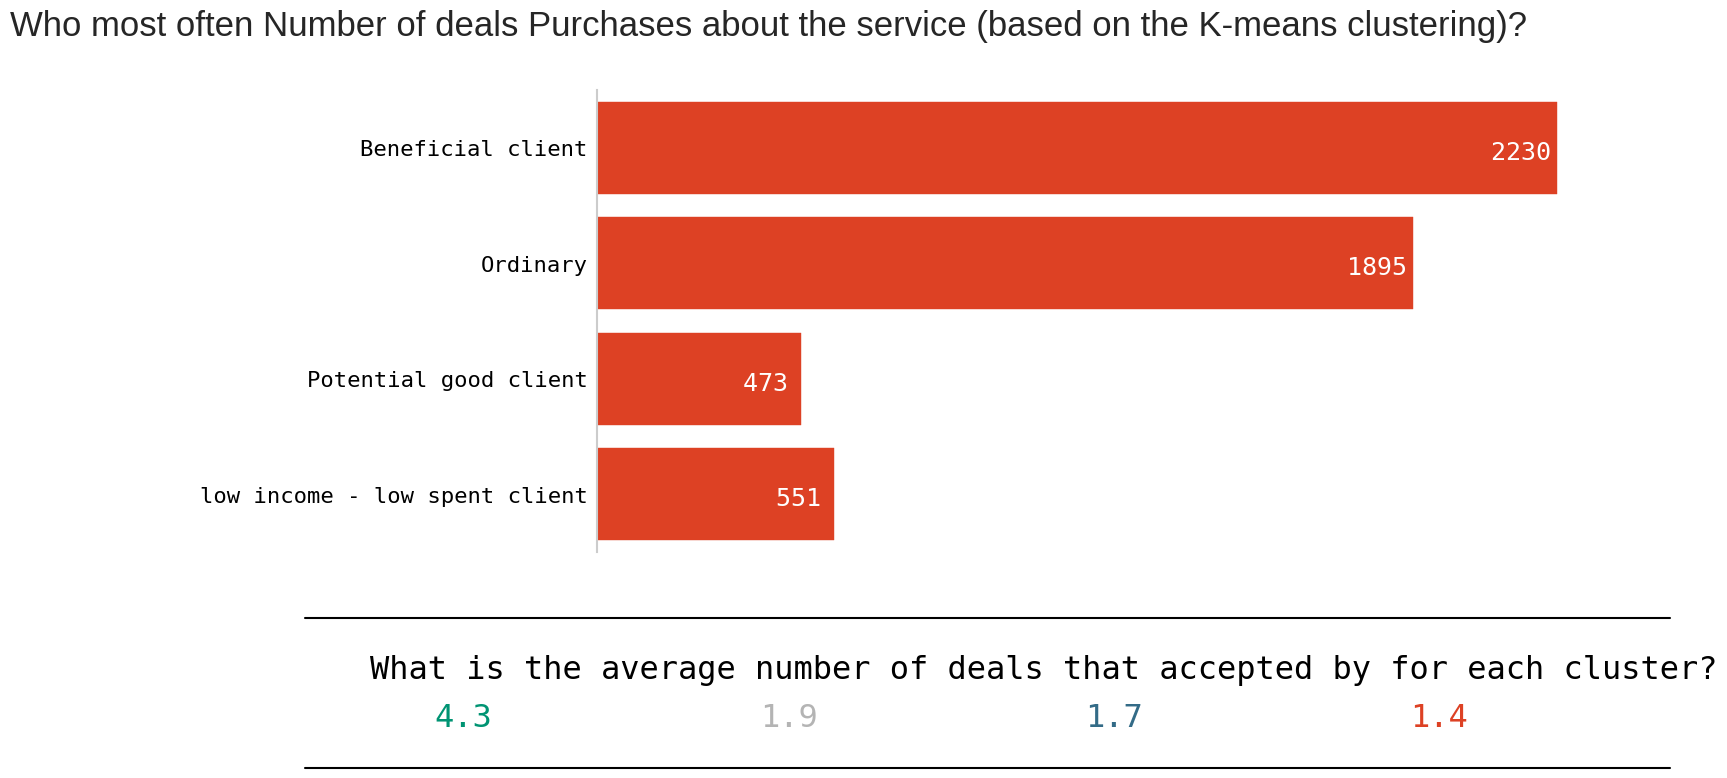

In [ ]:
cl  = [0,1,2,3]
# [, , ,,  "#ff6679"]
colors1 = {
             1:'#b4b4b4', 3:'#dd4124',0: '#009473',2: '#336b87'

}
fig = plt.figure(figsize = (13, 6))
plt.title('Who most often Number of deals Purchases about the service (based on the K-means clustering)?', size = 25, x = 0.17, y = 1.1)
a = sns.barplot(data = df4.groupby(['Cluster_KM']).agg({'NumDealsPurchases': 'sum'}).reset_index(),
                x = 'NumDealsPurchases', y = 'Cluster_KM')
plt.xticks([])
plt.yticks(fontname = 'monospace', size = 16, color = 'black')
plt.xlabel('')
plt.ylabel('')

for p in a.patches:
    width = p.get_width()
    plt.text(width - 100, p.get_y() + 0.55*p.get_height(), f'{width: .0f}',
             ha = 'center', va = 'center', fontname = 'monospace', fontsize = 18, color = 'white')
    print()
    if p.get_width() ==  398:
        p.set_color(colors1[0])
    elif p.get_width() == 2160:
        p.set_color(colors1[1])
    elif p.get_width() == 1904:
        p.set_color(colors1[2])
    else:
        p.set_color(colors1[3])
for j in ['right', 'top', 'bottom']:
    a.spines[j].set_visible(False)
a.spines['left'].set_linewidth(1.5)
from matplotlib import lines
l1 = lines.Line2D([-0.1, 0.95], [0, 0], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l1])

plt.figtext(-0.05, -0.1, 'What is the average number of deals that accepted by for each cluster?', fontname = 'monospace', size = 23, color = 'black')

x = 0
cl = 0
# colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']
for i in round(df4.groupby(['Cluster_KM']).agg({'NumDealsPurchases': 'mean'}).reset_index()['NumDealsPurchases'], 1):
    plt.figtext(x, -0.18, f'{i}', fontname = 'monospace', size = 23, color = colors1[cl])
    x += 0.25
    cl += 1

l2 = lines.Line2D([-0.1, 0.95], [-0.25, -0.25], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l2])


plt.show()

In [ ]:
df4.groupby(['Cluster_KM']).agg({'NumDealsPurchases': 'mean'})

NumDealsPurchases
Cluster_KM                                      
Beneficial client                       4.346979
Ordinary                                1.857843
Potential good client                   1.720000
low income - low spent client           1.350490

# 5.3 Customer Segment Analysis based on complain

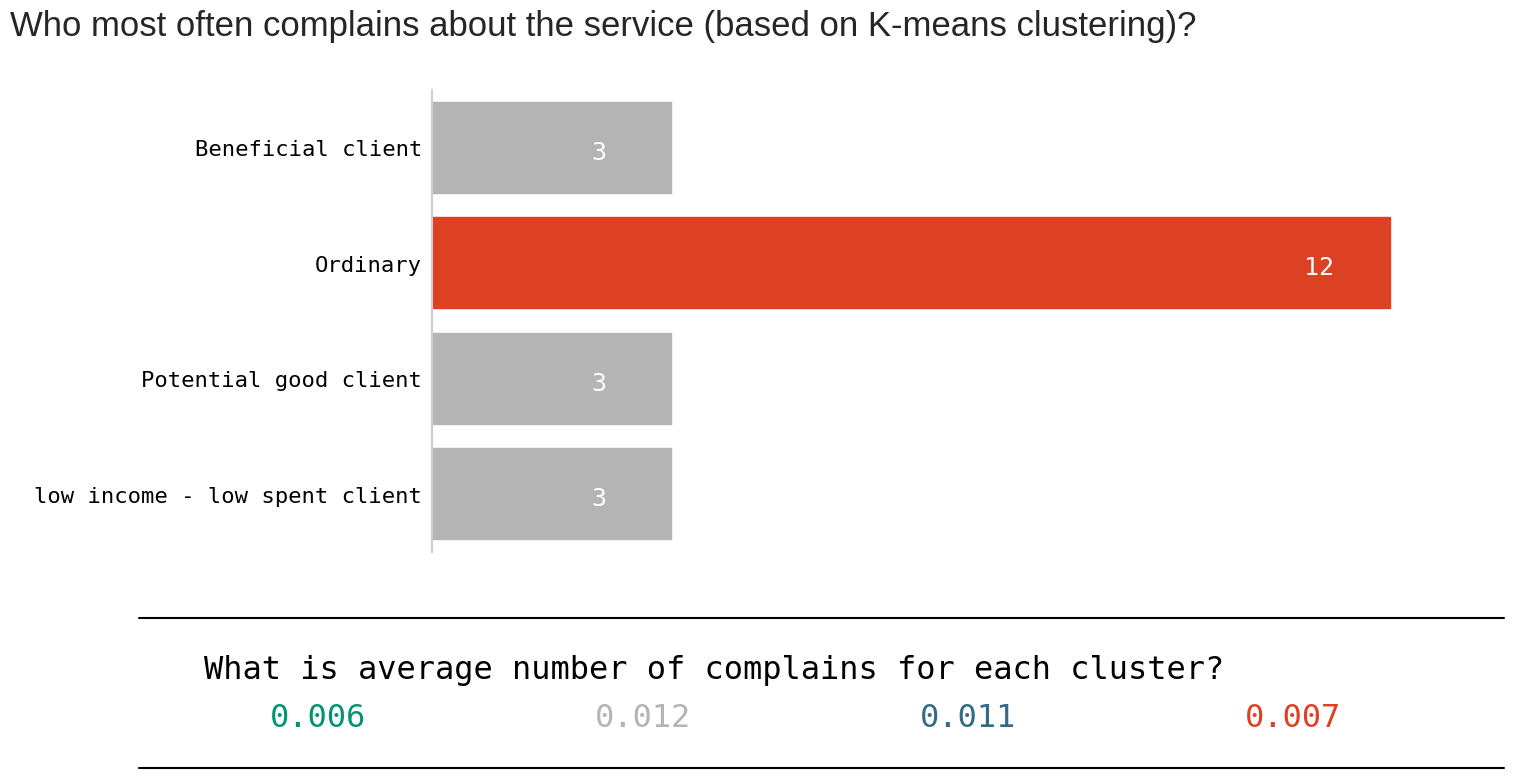

In [ ]:
cl  = [0,1,2,3]
# [, , ,,  "#ff6679"]
colors1 = {
             1:'#b4b4b4', 3:'#dd4124',0: '#009473',2: '#336b87'

}
fig = plt.figure(figsize = (13, 6))
plt.title('Who most often complains about the service (based on K-means clustering)?', size = 25, x = 0.17, y = 1.1)
a = sns.barplot(data = df4.groupby(['Cluster_KM']).agg({'Complain': 'sum'}).reset_index(),
                x = 'Complain', y = 'Cluster_KM')
plt.xticks([])
plt.yticks(fontname = 'monospace', size = 16, color = 'black')
plt.xlabel('')
plt.ylabel('')

for p in a.patches:
    width = p.get_width()
    plt.text(width - 1, p.get_y() + 0.55*p.get_height(), f'{width: .0f}',
             ha = 'center', va = 'center', fontname = 'monospace', fontsize = 18, color = 'white')
    print()
    if p.get_width() == 2:
        p.set_color(colors1[0])
    elif p.get_width() == 3:
        p.set_color(colors1[1])
    elif p.get_width() == 4:
        p.set_color(colors1[2])
    else:
        p.set_color(colors1[3])
for j in ['right', 'top', 'bottom']:
    a.spines[j].set_visible(False)
a.spines['left'].set_linewidth(1.5)
from matplotlib import lines
l1 = lines.Line2D([-0.1, 0.95], [0, 0], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l1])


plt.figtext(-0.05, -0.1, 'What is average number of complains for each cluster?', fontname = 'monospace', size = 23, color = 'black')

x = 0
cl = 0
# colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']
for i in round(df4.groupby(['Cluster_KM']).agg({'Complain': 'mean'}).reset_index()['Complain'] , 3):
    plt.figtext(x, -0.18, f'{i}', fontname = 'monospace', size = 23, color = colors1[cl])
    x += 0.25
    cl += 1

l2 = lines.Line2D([-0.1, 0.95], [-0.25, -0.25], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l2])


x = 0
cl = 0
# colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']

plt.show()

# 5.4 Customer Segment Analysis based on Household_size

In [ ]:
df4.groupby(['Cluster_KM']).agg({'Household_size': 'mean'})

Household_size
Cluster_KM                                   
Beneficial client                    2.986355
Ordinary                             2.850000
Potential good client                2.029091
low income - low spent client        1.833333

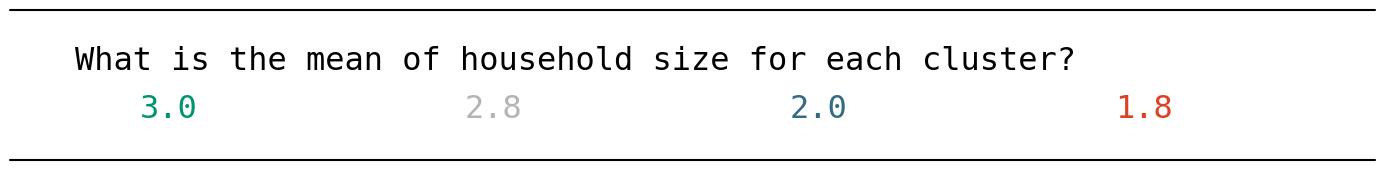

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Household_size"],hue=df4["Clusters_KMeans"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On Household_size And Spending with KMeans clustering")
# plot_clusters_income.legend()
# plt.show()

cl  = [0,1,2,3]
# [, , ,,  "#ff6679"]
colors1 = {
             1:'#b4b4b4', 3:'#dd4124',0: '#009473',2: '#336b87'

}
fig = plt.figure(figsize = (13, 6))



for j in ['right', 'top', 'bottom']:
    a.spines[j].set_visible(False)
a.spines['left'].set_linewidth(1.5)
from matplotlib import lines
l1 = lines.Line2D([-0.1, 0.95], [0, 0], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l1])

plt.figtext(-0.05, -0.1, 'What is the mean of household size for each cluster?', fontname = 'monospace', size = 23, color = 'black')

x = 0
cl = 0
# colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']
for i in round(df4.groupby(['Cluster_KM']).agg({'Household_size': 'mean'}).reset_index()['Household_size'] , 1):
    plt.figtext(x, -0.18, f'{i}', fontname = 'monospace', size = 23, color = colors1[cl])
    x += 0.25
    cl += 1

l2 = lines.Line2D([-0.1, 0.95], [-0.25, -0.25], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l2])


plt.show()

# 5.5 Customer Segment Analysis based on Education

In [ ]:
df["Cluster_KM"] = df4['Cluster_KM']

In [ ]:
df4.groupby(['Cluster_KM']).agg({'NumWebPurchases': 'mean'})

NumWebPurchases
Cluster_KM                                    
Beneficial client                     6.183236
Ordinary                              2.083333
Potential good client                 5.749091
low income - low spent client         5.330882

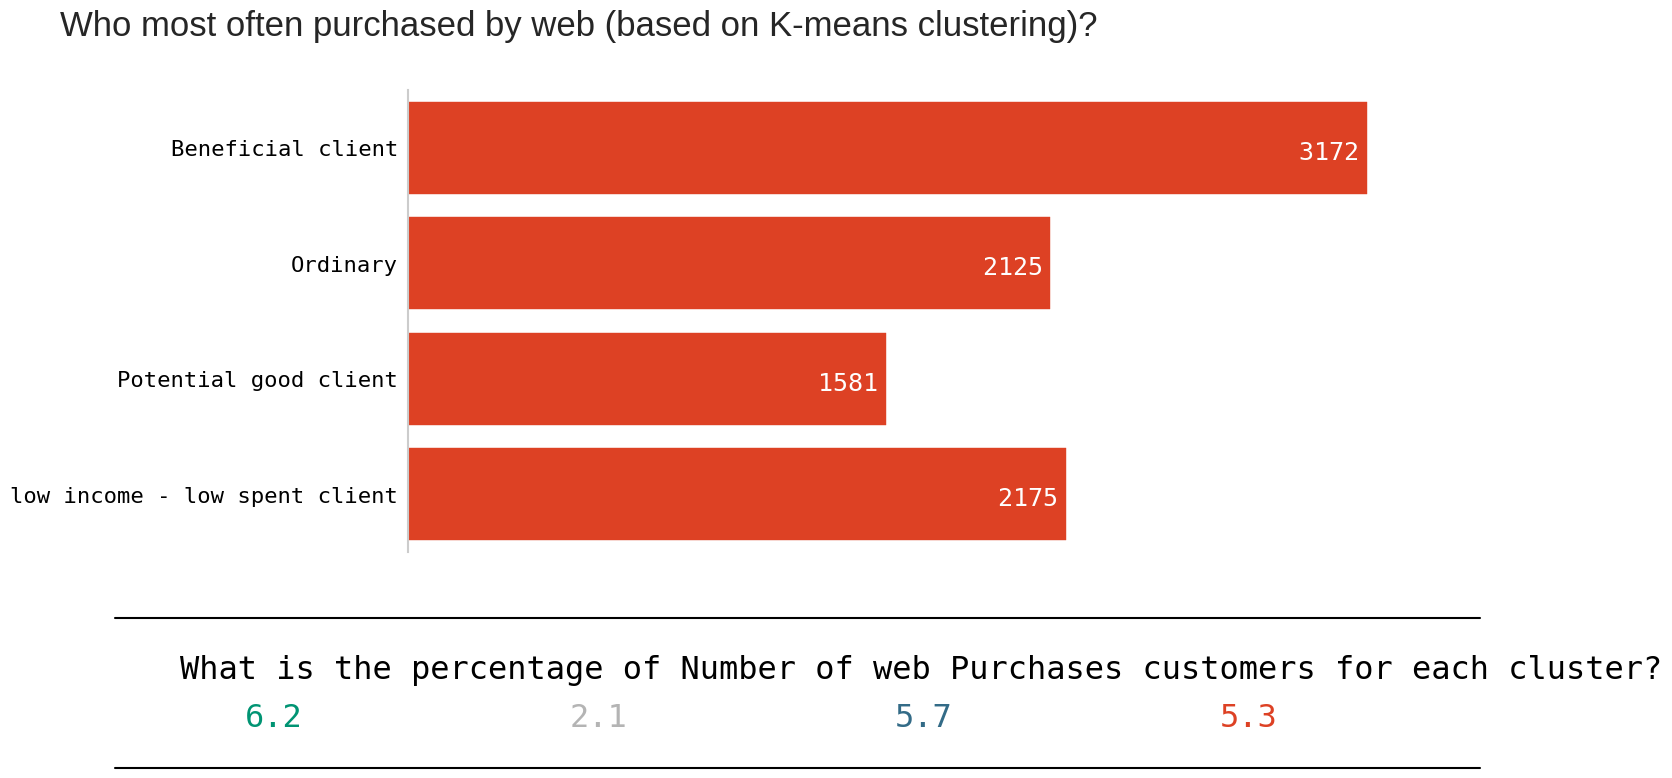

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Education"],hue=df4["Clusters_KMeans"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On Education And Spending with KMeans clustering")
# plot_clusters_income.legend()
# plt.show()

cl  = [0,1,2,3]
# [, , ,,  "#ff6679"]
colors1 = {
             1:'#b4b4b4', 3:'#dd4124',0: '#009473',2: '#336b87'

}
fig = plt.figure(figsize = (13, 6))
plt.title('Who most often purchased by web (based on K-means clustering)?', size = 25, x = 0.17, y = 1.1)
a = sns.barplot(data = df4.groupby(['Cluster_KM']).agg({'NumWebPurchases': 'sum'}).reset_index(),
                x = 'NumWebPurchases', y = 'Cluster_KM')
plt.xticks([])
plt.yticks(fontname = 'monospace', size = 16, color = 'black')
plt.xlabel('')
plt.ylabel('')

for p in a.patches:
    width = p.get_width()
    plt.text(width - 150, p.get_y() + 0.55*p.get_height(), f'{width: .0f}',
             ha = 'center', va = 'center', fontname = 'monospace', fontsize = 18, color = 'white')
    print()
    if p.get_width() == 1415:
        p.set_color(colors1[0])
    elif p.get_width() == 3000:
        p.set_color(colors1[1])
    elif p.get_width() == 2470:
        p.set_color(colors1[2])
    else:
        p.set_color(colors1[3])
for j in ['right', 'top', 'bottom']:
    a.spines[j].set_visible(False)
a.spines['left'].set_linewidth(1.5)
from matplotlib import lines
l1 = lines.Line2D([-0.1, 0.95], [0, 0], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l1])

plt.figtext(-0.05, -0.1, 'What is the percentage of Number of web Purchases customers for each cluster?', fontname = 'monospace', size = 23, color = 'black')

x = 0
cl = 0
# colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']
for i in round(df4.groupby(['Cluster_KM']).agg({'NumWebPurchases': 'mean'}).reset_index()['NumWebPurchases'] , 1):
    plt.figtext(x, -0.18, f'{i}', fontname = 'monospace', size = 23, color = colors1[cl])
    x += 0.25
    cl += 1

l2 = lines.Line2D([-0.1, 0.95], [-0.25, -0.25], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l2])

plt.show()

In [ ]:
df4.groupby(['Cluster_KM']).agg({'NumStorePurchases': 'mean'})

NumStorePurchases
Cluster_KM                                      
Beneficial client                       7.222222
Ordinary                                3.295098
Potential good client                   8.516364
low income - low spent client           8.448529

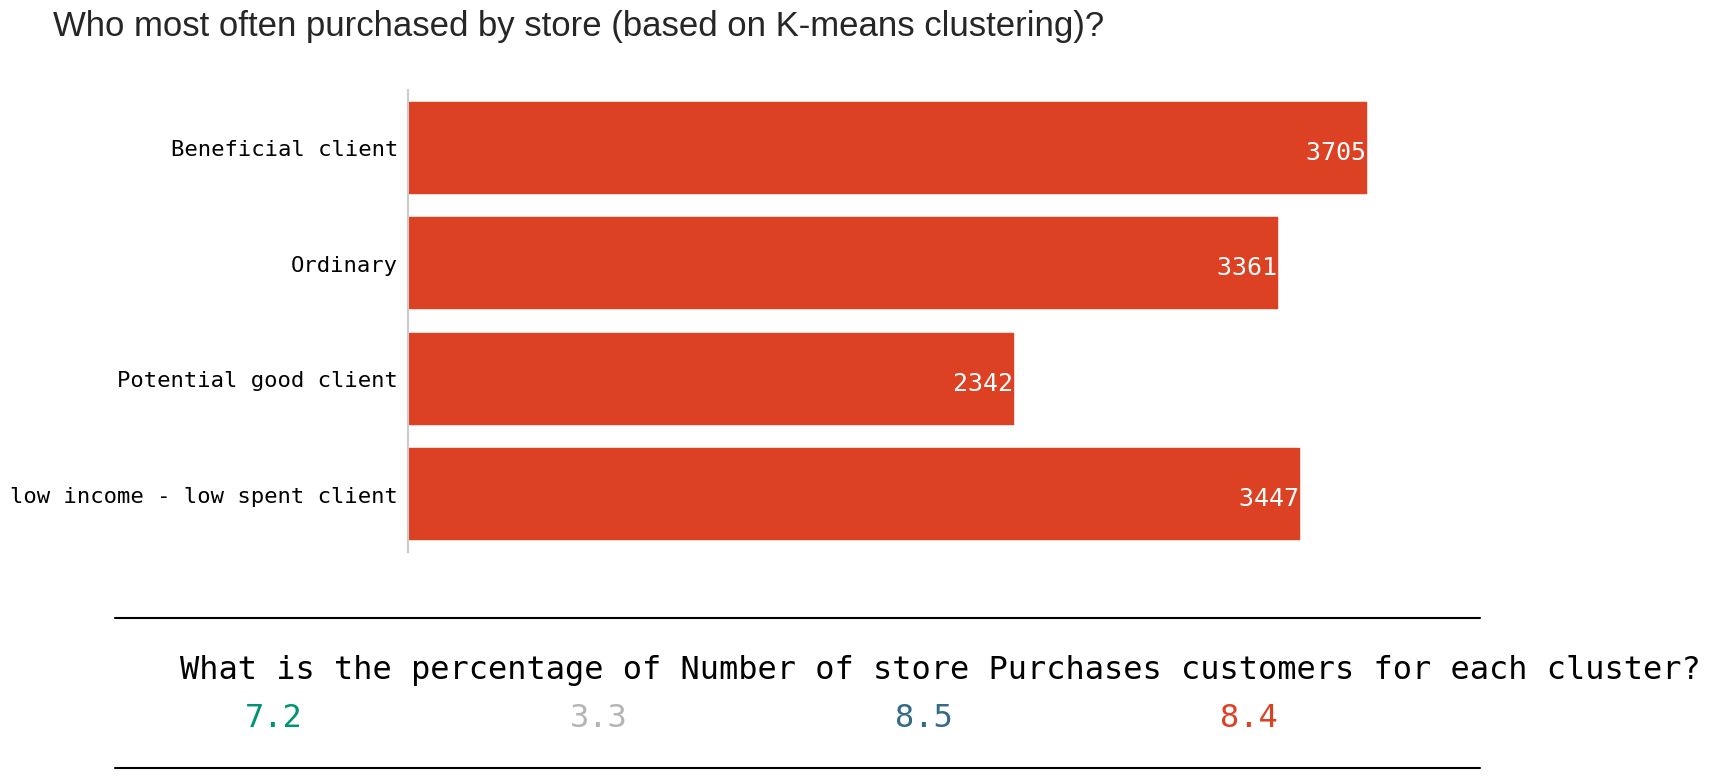

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Education"],hue=df4["Clusters_KMeans"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On Education And Spending with KMeans clustering")
# plot_clusters_income.legend()
# plt.show()

# behavior = ['Total_spent',  'NumWebPurchases',
#        'NumCatalogPurchases', 'NumStorePurchases',
#        'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#        'AcceptedCmp1',  'Response']

cl  = [0,1,2,3]
# [, , ,,  "#ff6679"]

colors1 = {
             1:'#b4b4b4', 2:'#336b87',0: '#009473',3: '#dd4124'

}
fig = plt.figure(figsize = (13, 6))
plt.title('Who most often purchased by store (based on K-means clustering)?', size = 25, x = 0.17, y = 1.1)
a = sns.barplot(data = df4.groupby(['Cluster_KM']).agg({'NumStorePurchases': 'sum'}).reset_index(),
                x = 'NumStorePurchases', y = 'Cluster_KM')
plt.xticks([])
plt.yticks(fontname = 'monospace', size = 16, color = 'black')
plt.xlabel('')
plt.ylabel('')

for p in a.patches:
    width = p.get_width()
    plt.text(width - 150, p.get_y() + 0.55*p.get_height(), f'{width: .0f}',
             ha = 'center', va = 'center', fontname = 'monospace', fontsize = 18, color = 'white')
    print()
    if p.get_width() == 2116:
        p.set_color(colors1[0])
    elif p.get_width() == 3497:
        p.set_color(colors1[1])
    elif p.get_width() == 3860:
        p.set_color(colors1[2])
    else:
        p.set_color(colors1[3])
for j in ['right', 'top', 'bottom']:
    a.spines[j].set_visible(False)
a.spines['left'].set_linewidth(1.5)
from matplotlib import lines
l1 = lines.Line2D([-0.1, 0.95], [0, 0], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l1])

plt.figtext(-0.05, -0.1, 'What is the percentage of Number of store Purchases customers for each cluster?', fontname = 'monospace', size = 23, color = 'black')

x = 0
cl = 0
# colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']
for i in round(df4.groupby(['Cluster_KM']).agg({'NumStorePurchases': 'mean'}).reset_index()['NumStorePurchases'] , 1):
    plt.figtext(x, -0.18, f'{i}', fontname = 'monospace', size = 23, color = colors1[cl])
    x += 0.25
    cl += 1

l2 = lines.Line2D([-0.1, 0.95], [-0.25, -0.25], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l2])

plt.show()

In [ ]:
df4.groupby(['Cluster_KM']).agg({'NumCatalogPurchases': 'mean'})

NumCatalogPurchases
Cluster_KM                                        
Beneficial client                         2.923977
Ordinary                                  0.557843
Potential good client                     5.461818
low income - low spent client             5.754902

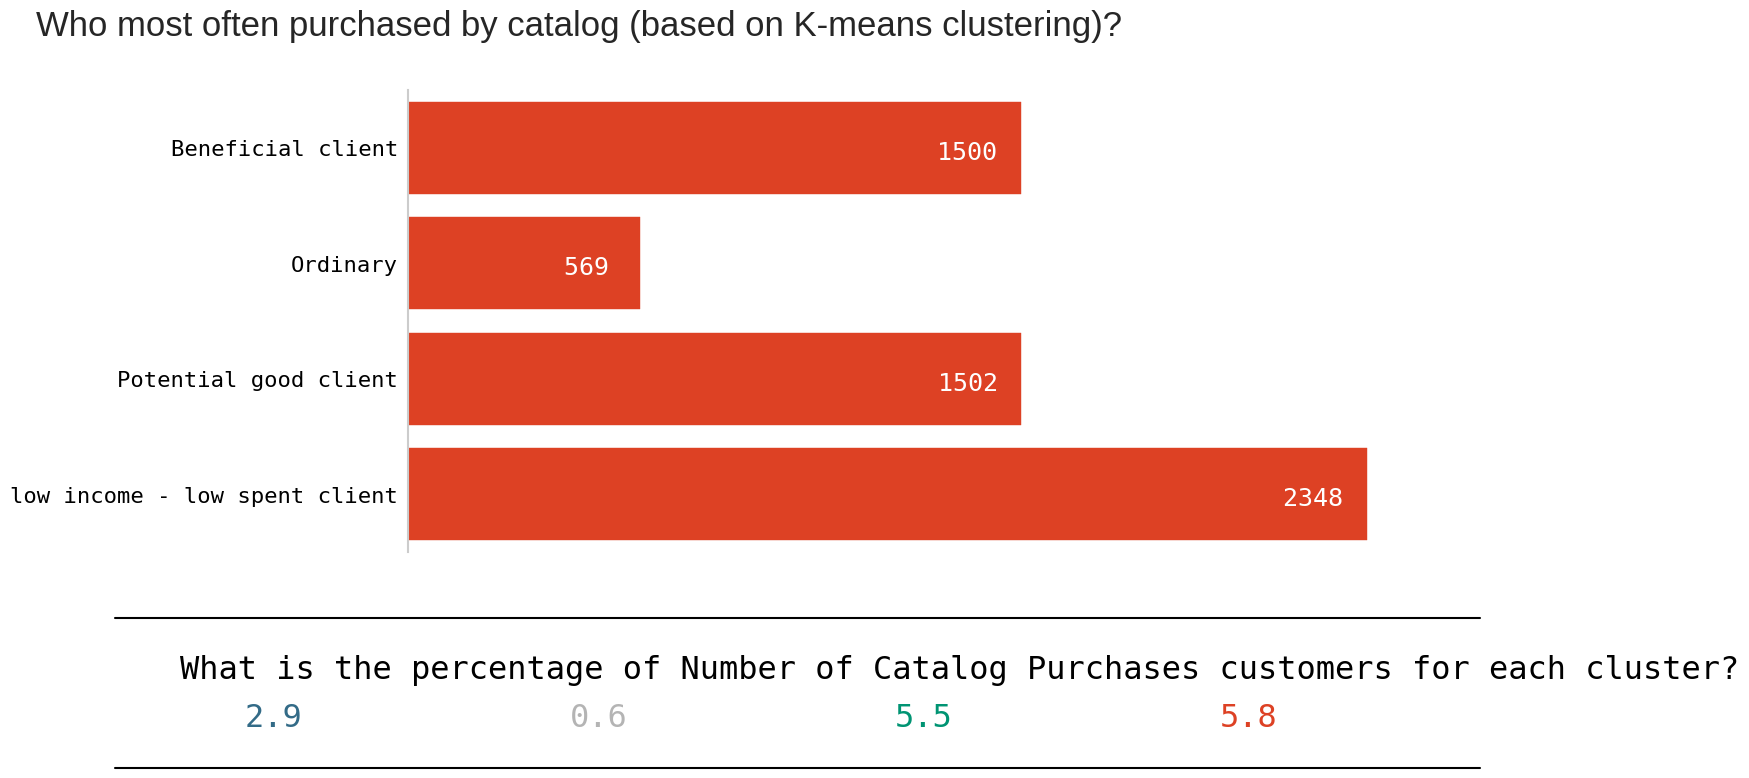

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Education"],hue=df4["Clusters_KMeans"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On Education And Spending with KMeans clustering")
# plot_clusters_income.legend()
# plt.show()

# behavior = ['Total_spent',  'NumWebPurchases',
#        'NumCatalogPurchases', 'NumStorePurchases',
#        'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#        'AcceptedCmp1',  'Response']

cl  = [0,1,2,3]
# [, , ,,  "#ff6679"]
colors1 = {
             1:'#b4b4b4', 0:'#336b87',2: '#009473',3: '#dd4124'

}
fig = plt.figure(figsize = (13, 6))
plt.title('Who most often purchased by catalog (based on K-means clustering)?', size = 25, x = 0.17, y = 1.1)
a = sns.barplot(data = df4.groupby(['Cluster_KM']).agg({'NumCatalogPurchases': 'sum'}).reset_index(),
                x = 'NumCatalogPurchases', y = 'Cluster_KM')
plt.xticks([])
plt.yticks(fontname = 'monospace', size = 16, color = 'black')
plt.xlabel('')
plt.ylabel('')

for p in a.patches:
    width = p.get_width()
    plt.text(width - 150, p.get_y() + 0.55*p.get_height(), f'{width: .0f}',
             ha = 'center', va = 'center', fontname = 'monospace', fontsize = 18, color = 'white')
    print()
    if p.get_width() == 1413:
        p.set_color(colors1[2])
    elif p.get_width() == 1403:
        p.set_color(colors1[1])
    elif p.get_width() == 2532:
        p.set_color(colors1[0])
    else:
        p.set_color(colors1[3])
for j in ['right', 'top', 'bottom']:
    a.spines[j].set_visible(False)
a.spines['left'].set_linewidth(1.5)
from matplotlib import lines
l1 = lines.Line2D([-0.1, 0.95], [0, 0], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l1])

plt.figtext(-0.05, -0.1, 'What is the percentage of Number of Catalog Purchases customers for each cluster?', fontname = 'monospace', size = 23, color = 'black')

x = 0
cl = 0
# colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']
for i in round(df4.groupby(['Cluster_KM']).agg({'NumCatalogPurchases': 'mean'}).reset_index()['NumCatalogPurchases'] , 1):
    plt.figtext(x, -0.18, f'{i}', fontname = 'monospace', size = 23, color = colors1[cl])
    x += 0.25
    cl += 1

l2 = lines.Line2D([-0.1, 0.95], [-0.25, -0.25], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
fig.lines.extend([l2])

plt.show()

In [ ]:
# # plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Education"],hue=df4["Clusters_KMeans"], palette= palette)
# # plot_clusters_income.set_title("Cluster's Profile Based On Education And Spending with KMeans clustering")
# # plot_clusters_income.legend()
# # plt.show()

# # behavior = ['Total_spent',  'NumWebPurchases',
# #        'NumCatalogPurchases', 'NumStorePurchases',
# #        'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
# #        'AcceptedCmp1',  'Response']
#               # 'Potential good client':'#336b87', 'Beneficial client': '#009473','low income - low spent client':'#dd4124','Ordinary': '#b4b4b4'

# cl  = [0,1,2,3]
# # [, , ,,  "#ff6679"]
# colors1 = {
#              0:'#b4b4b4', 1:'#336b87',2: '#009473',3:'#dd4124'

# }
# fig = plt.figure(figsize = (13, 6))
# plt.title('Who most often purchased by catalog (based on K-means clustering)?', size = 25, x = 0.17, y = 1.1)
# a = sns.barplot(data = df4.groupby(['Cluster_KM']).agg({'Is_parent': 'size'}).reset_index(),
#                 x = 'NumCatalogPurchases', y = 'Cluster_KM')
# plt.xticks([])
# plt.yticks(fontname = 'monospace', size = 16, color = 'black')
# plt.xlabel('')
# plt.ylabel('')

# for p in a.patches:
#     width = p.get_width()
#     plt.text(width - 150, p.get_y() + 0.55*p.get_height(), f'{width: .0f}',
#              ha = 'center', va = 'center', fontname = 'monospace', fontsize = 18, color = 'white')
#     print()
#     if p.get_width() == 1413:
#         p.set_color(colors1[2])
#     elif p.get_width() == 1403:
#         p.set_color(colors1[0])
#     elif p.get_width() == 2532:
#         p.set_color(colors1[3])
#     else:
#         p.set_color(colors1[1])
# for j in ['right', 'top', 'bottom']:
#     a.spines[j].set_visible(False)
# a.spines['left'].set_linewidth(1.5)
# from matplotlib import lines
# l1 = lines.Line2D([-0.1, 0.95], [0, 0], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
# fig.lines.extend([l1])

# plt.figtext(-0.05, -0.1, 'What is the percentage of Number of Catalog Purchases customers for each cluster?', fontname = 'monospace', size = 23, color = 'black')

# x = 0
# cl = 0
# # colors = ['#dd4124', '#009473', '#336b87', '#b4b4b4']
# for i in round(df4.groupby(['Cluster_KM']).agg({'NumCatalogPurchases': 'mean'}).reset_index()['NumCatalogPurchases'] , 1):
#     plt.figtext(x, -0.18, f'{i}', fontname = 'monospace', size = 23, color = colors1[cl])
#     x += 0.25
#     cl += 1

# l2 = lines.Line2D([-0.1, 0.95], [-0.25, -0.25], transform = fig.transFigure, figure = fig, color = 'black', linestyle = '-',linewidth = 1.5)
# fig.lines.extend([l2])

# plt.show()

# 5.6 Customer Segment Analysis on different products

In [ ]:
df4.groupby(['Clusters_KMeans']).agg({'MntWines': 'sum', 'MntFruits': 'sum', 'MntMeatProducts': 'sum', 'MntFishProducts': 'sum', 'MntSweetProducts': 'sum', 'MntGoldProds': 'sum'})

MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Clusters_KMeans                                                          
0                  144995      28322           114919            34461   
1                  223152       8173            63019            10967   
2                  262731      16789           169022            30610   
3                   45205       5121            23103             7367   

                 MntSweetProducts  MntGoldProds  
Clusters_KMeans                                  
0                           29087         25913  
1                            8202         30204  
2                           17399         26635  
3                            5208         14675

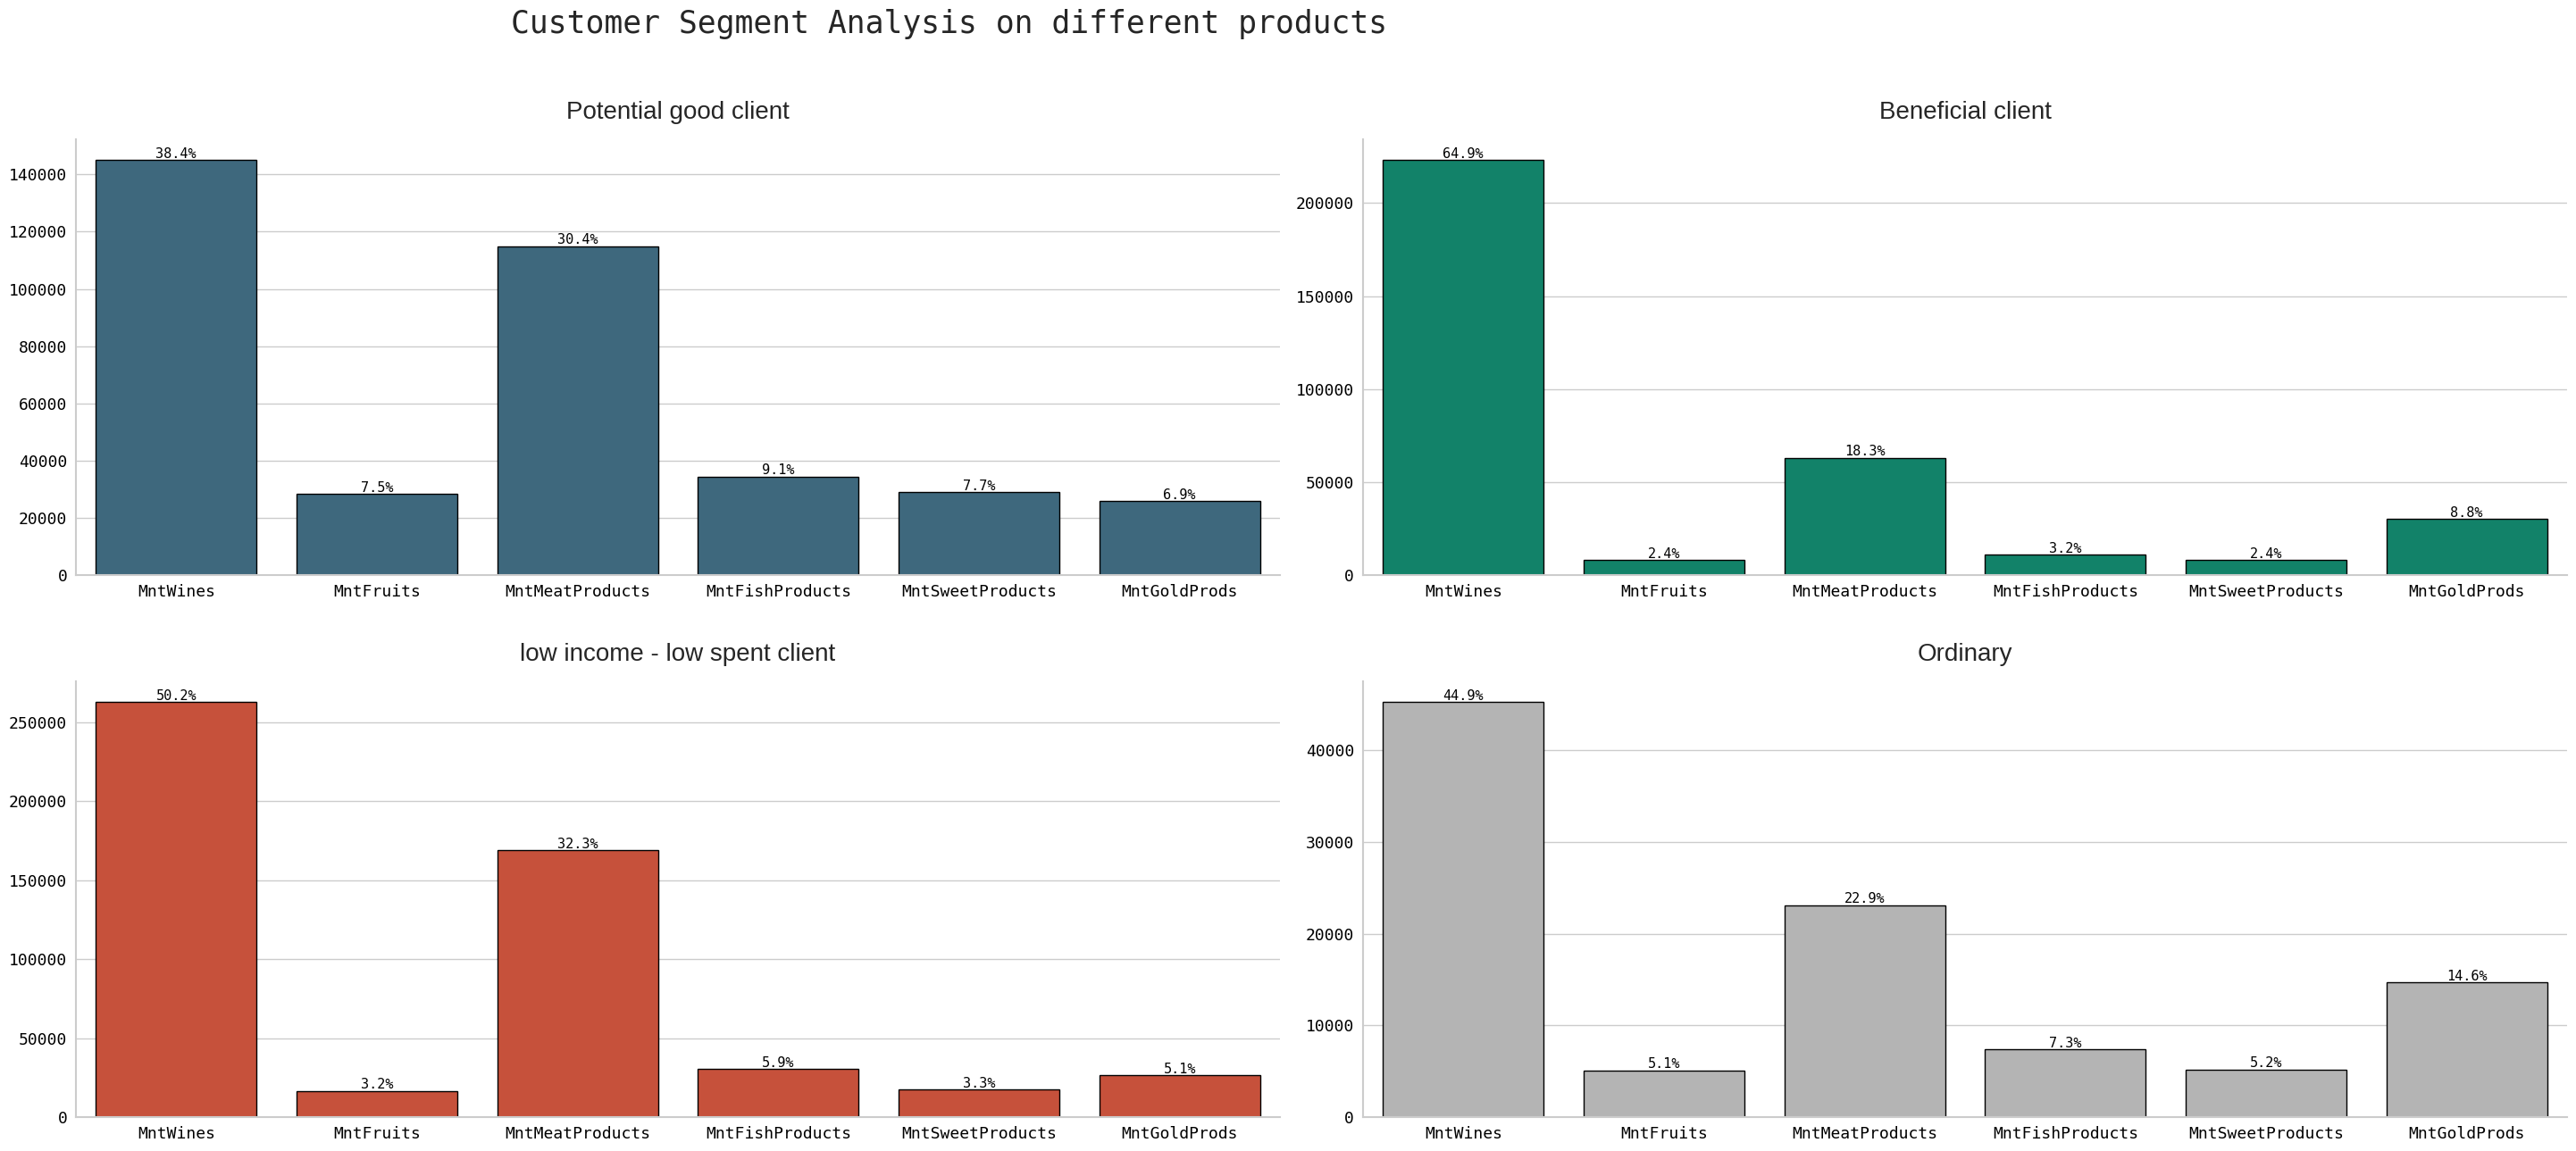

In [ ]:
fig = plt.figure(figsize = (29, 12))
k = 1
cl  = [ 'Potential good client','Beneficial client','low income - low spent client', 'Ordinary']
# [, , ,,  "#ff6679"]
colors1 = {
              'Potential good client':'#336b87', 'Beneficial client': '#009473','low income - low spent client':'#dd4124','Ordinary': '#b4b4b4'

}

for i in cl:
    ss = df4.groupby(['Cluster_KM']).agg({'MntWines': 'sum', 'MntFruits': 'sum', 'MntMeatProducts': 'sum', 'MntFishProducts': 'sum', 'MntSweetProducts': 'sum', 'MntGoldProds': 'sum'}).transpose().reset_index().rename(columns = {'index': 'Category'})[['Category', i]]
    plt.subplot(2, 2, k)
    plt.title(i, size = 20, x = 0.5, y = 1.03)
    a = sns.barplot(data = ss, x = 'Category', y = i, color = colors1[i],
                   linestyle = "-", linewidth = 1,
                   edgecolor = "black")
    plt.xticks(fontname = 'monospace', size = 13, color = 'black')
    plt.yticks(fontname = 'monospace', size = 13, color = 'black')
    plt.xlabel('')
    plt.ylabel('')
    for p in a.patches:
        height = p.get_height()
        a.annotate(f'{round((height / sum(ss[i])) * 100, 1)}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha = 'center', va = 'center',
                   size = 11,
                   xytext = (0, 5),
                   textcoords = 'offset points',
                   fontname = 'monospace', color = 'black')

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    for j in ['bottom', 'left']:
        a.spines[j].set_linewidth(1.5)
    k += 1

# plt.figtext(0.05, -0.05, 'Conclusion', fontname = 'monospace', size = 22, color = '#dd4124')
# plt.figtext(0.05, -0.14, '''We are definitely dealing with a store that sells very good wine, which is almost equally bought by all clusters
# of buyers. In general, there are no major differences, except that customers from ordinary and potential
# good clusters are more likely to buy gold and customers from good and elite clusters are more likely to
# buy meat more often.''', fontname = 'monospace', size = 14, color = 'black')

plt.figtext(0.2, 1.05, 'Customer Segment Analysis on different products', fontname = 'monospace', size = 25)
fig.tight_layout(h_pad = 3)
plt.show()

In [ ]:
# from mlxtend.preprocessing import TransactionEncoder

# te = TransactionEncoder()
# te_ary = te.fit(association).transform(association)
# df3 = pd.DataFrame(te_ary, columns=te.columns_)


In [ ]:
# df3.head()

In [ ]:
# from mlxtend.frequent_patterns import apriori, association_rules

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', 999)
# pd.options.display.float_format = "{:.3f}".format

# association=df2.copy()
# association["cluster"] = df["Cluster_gussian"]
# # association.drop(columns=[])
# data = pd.get_dummies(association)
# # print(data.head(//))
# #Apriori min support
# min_support = 0.08

# #Max lenght of apriori n-grams
# max_len = 10

# frequent_items = apriori(data, use_colnames=True, min_support=min_support, max_len=max_len + 1)
# rules = association_rules(frequent_items, metric='lift', min_threshold=1)

# 5.7 Customer Segment Analysis based on all features using hierarchal clustering

In [ ]:
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white', 'axes.grid' : True, 'font.family': 'DejaVu Sans'})

# for i in df:
#     if (i=="Clusters_optics")or (i=="Clusters_DBSCAN")or (i=="Clusters_KMeans"):
#       continue
#     g = sns.FacetGrid(df4, col = "Clusters_hi", hue = "Clusters_hi", palette = "Set2")
#     # bins = np.linspace(df[i].min(),df[i].max(),100)
#     g.map(plt.hist, i, bins=10, ec="k")
#     g.set_xticklabels(rotation=30, color = 'black')
#     g.set_yticklabels( color = 'green')
#     g.set_xlabels(size=15, color = 'black')
#     g.set_ylabels(size=15, color = 'black')
#     g.set_titles(size=15, color = 'black', fontweight="bold")
#     g.fig.set_figheight(5)

In [ ]:
# product='Wines'
# segment='Biggest consumer'
# target = '{\'%s_segment_%s\'}' %(product,segment)

# results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)

# results_personnal_care.head(5)

# 5.8 Customer Segment Analysis based on income And spending using Agglomerative clustering

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df4,x=df4["Total_spent"], y=df4["Income"],hue=df4["Clusters_hi"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On Income And Spending with Agglomerative clustering")
# plot_clusters_income.legend()
# plt.show()

# 5.9 Customer Segment Analysis based on income And spending using KMeans clustering

<ipython-input-104-54d11edbd578>:1: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



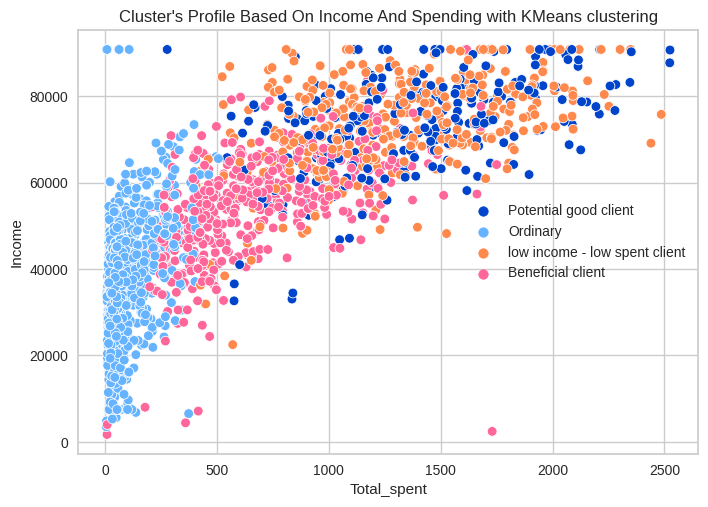

In [ ]:
plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Income"],hue=df4["Cluster_KM"], palette= palette)
plot_clusters_income.set_title("Cluster's Profile Based On Income And Spending with KMeans clustering")
plot_clusters_income.legend()
plt.show()

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Household_size"],hue=df4["Clusters_KMeans"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On Household_size And Spending with KMeans clustering")
# plot_clusters_income.legend()
# plt.show()

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["Education"],hue=df4["Clusters_KMeans"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On Education And Spending with KMeans clustering")
# plot_clusters_income.legend()
# plt.show()

In [ ]:
# plot_clusters_income = sns.scatterplot(data = df,x=df4["NumDealsPurchases"], y=df4["Total_spent"],hue=df4["Clusters_KMeans"], palette= palette)
# plot_clusters_income.set_title("Cluster's Profile Based On NumDealsPurchases And Spending with KMeans clustering")
# plot_clusters_income.legend()
# plt.show()

# 5.10 Customer Segment Analysis based on income And spending using DBscan clustering

In [ ]:
# 'Total_spent',  'NumWebPurchases',
#        'NumCatalogPurchases', 'NumStorePurchases',
#        'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#        'AcceptedCmp1',  'Response']
# i=0

<ipython-input-109-ced0727d1ea0>:1: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



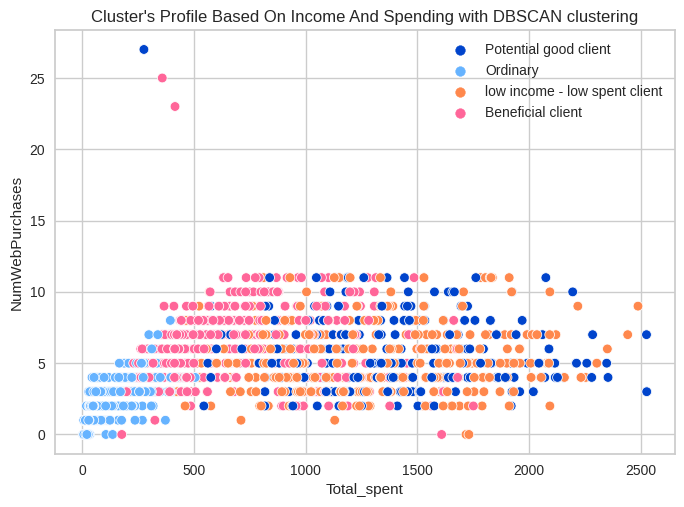

In [ ]:
plot_clusters_income = sns.scatterplot(data = df,x=df4["Total_spent"], y=df4["NumWebPurchases"],hue=df4["Cluster_KM"], palette= palette)
plot_clusters_income.set_title("Cluster's Profile Based On Income And Spending with DBSCAN clustering")
plot_clusters_income.legend()
plt.show()

In [ ]:
df.columns


Index(['Age', 'Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'Web', 'Catalog', 'Store',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'AcceptedCmp6',
       'Days_with_market', 'Total_spent', 'Total_Offer', 'Num_Total_Purchases',
       'Household_size', 'Is_parent', 'NumTotalPurchases', 'Clusters_hi',
       'Clusters_KMeans', 'Clusters_DBSCAN', 'Clusters_optics',
       'Cluster_gaussian', 'Cluster_KM'],
      dtype='object')

# 5.11 Customer Segment Analysis based on Education And spending using DBscan clustering

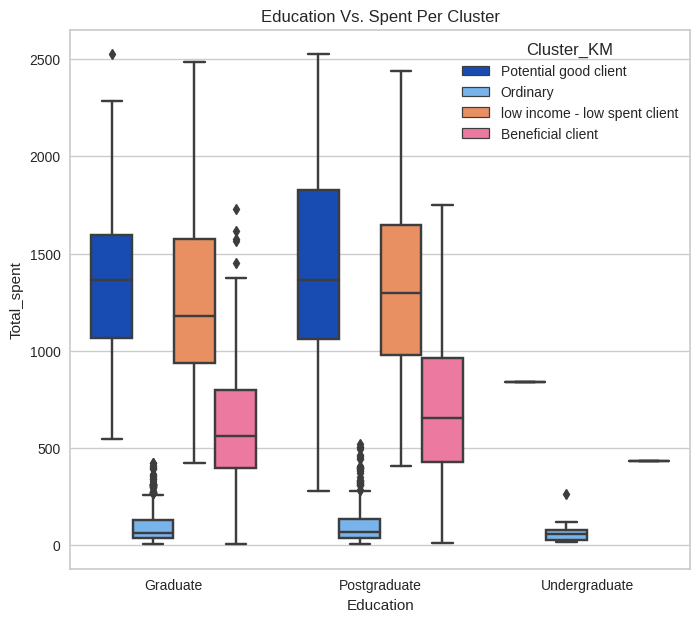

In [ ]:
plt.figure(figsize=(8,7))
pl=sns.boxplot(x=df4['Education'],y=df4['Total_spent'],hue=df4["Cluster_KM"], palette= palette)
pl.set_title("Education Vs. Spent Per Cluster")
plt.show()

In [ ]:
df4.groupby(['Cluster_KM',"Household_size"]).size()

Cluster_KM                     Household_size
Beneficial client              1                   5
                               2                 124
                               3                 269
                               4                 103
                               5                  12
Ordinary                       1                  47
                               2                 283
                               3                 485
                               4                 186
                               5                  19
Potential good client          1                  66
                               2                 141
                               3                  62
                               4                   6
low income - low spent client  1                 134
                               2                 209
                               3                  64
                               4                   1


In [ ]:
df4.groupby(['Cluster_KM',"Marital_Status"]).size()

Cluster_KM                     Marital_Status
Beneficial client                                  2
                               Partner           355
                               Single            156
Ordinary                       Partner           662
                               Single            358
Potential good client          Partner           176
                               Single             99
low income - low spent client  Partner           237
                               Single            171
dtype: int64

In [ ]:
df4.groupby(['Cluster_KM']).agg({"NumCatalogPurchases":'mean'})

NumCatalogPurchases
Cluster_KM                                        
Beneficial client                         2.923977
Ordinary                                  0.557843
Potential good client                     5.461818
low income - low spent client             5.754902

In [ ]:
df4.groupby(['Cluster_KM',"Is_parent"]).agg({"Is_parent":'size'})

Is_parent
Cluster_KM                    Is_parent           
Beneficial client             0                 16
                              1                497
Ordinary                      0                130
                              1                890
Potential good client         0                178
                              1                 97
low income - low spent client 0                309
                              1                 99

In [ ]:
df4.groupby(['Cluster_KM',"Education"]).agg({"Education":'size'})

Education
Cluster_KM                    Education               
Beneficial client             Graduate             243
                              Postgraduate         269
                              Undergraduate          1
Ordinary                      Graduate             493
                              Postgraduate         475
                              Undergraduate         52
Potential good client         Graduate             183
                              Postgraduate          91
                              Undergraduate          1
low income - low spent client Graduate             197
                              Postgraduate         211

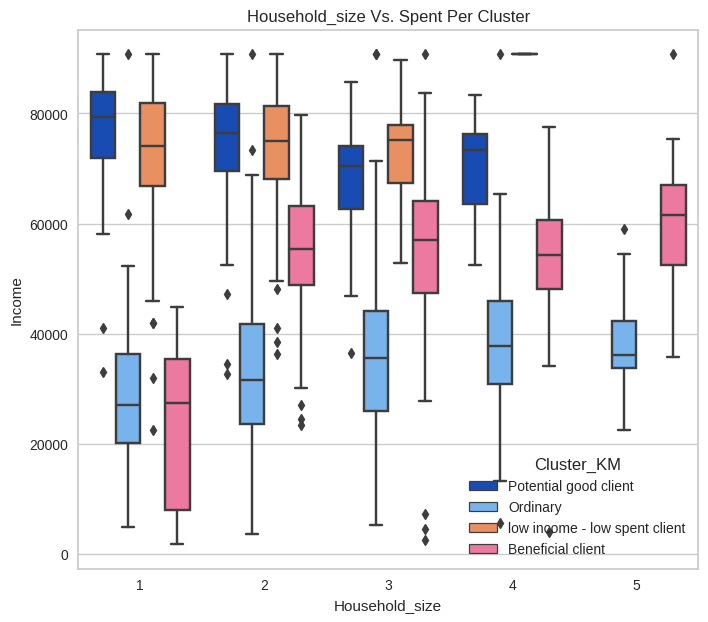

In [ ]:
plt.figure(figsize=(8,7))
pl=sns.boxplot(x=df4['Household_size'],y=df4["Income"],hue=df4["Cluster_KM"], palette= palette)
pl.set_title("Household_size Vs. Spent Per Cluster")
plt.show()

# 5.12 Customer Segment Analysis based on Education And income using DBscan clustering

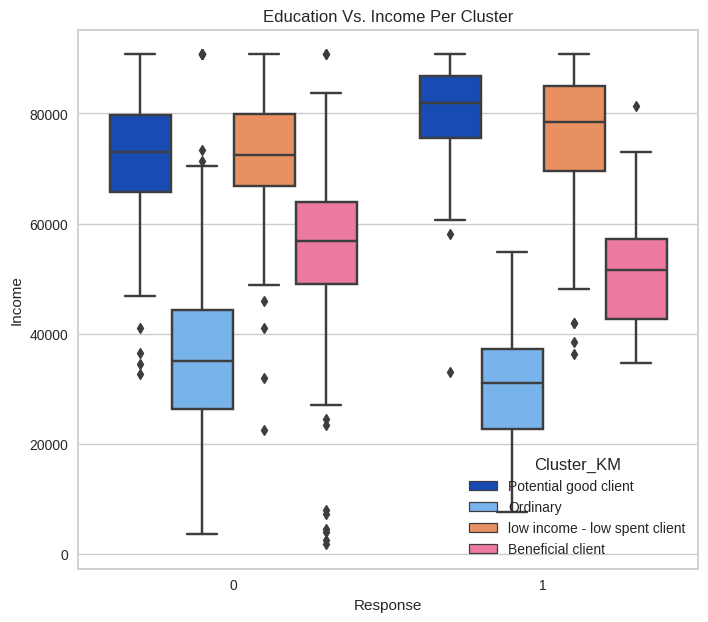

In [ ]:
plt.figure(figsize=(8,7))
pl=sns.boxplot(x=df4['Response'],y=df4['Income'],hue=df4["Cluster_KM"], palette= palette)
pl.set_title("Education Vs. Income Per Cluster")
plt.show()

In [ ]:
df4.columns

Index(['Age', 'Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Days_with_market',
       'Total_spent', 'Total_Offer', 'Num_Total_Purchases', 'Household_size',
       'Is_parent', 'NumTotalPurchases', 'Clusters_KMeans', 'Cluster_gaussian',
       'Cluster_KM', 'Clusters_hi'],
      dtype='object')

In [ ]:
# i=0
# char = ["Income","Education","Age","Kidhome","Teenhome"]
# for col in char:
#     if i%3==0:
#         fig, ax = plt.subplots(1,3)
#         fig.set_size_inches(25,8)
#     sns.kdeplot(data=df, x=col, hue="Clusters_hi", fill=True,ax=ax[i%3])
#     ax[i%3].set_title(col)
#     i+=1

<ipython-input-121-99da72166bc8>:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.

<ipython-input-121-99da72166bc8>:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.

<ipython-input-121-99da72166bc8>:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.

<ipython-input-121-99da72166bc8>:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.

<ipython-input-121-99da72166bc8>:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.

<ipython-input-121-99da72166bc8>:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.

<ipython-input-121-99da72166bc8>:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.

<ipython-input-121-99da72166bc8>:12: UserWarning:

Dataset has 0 vari

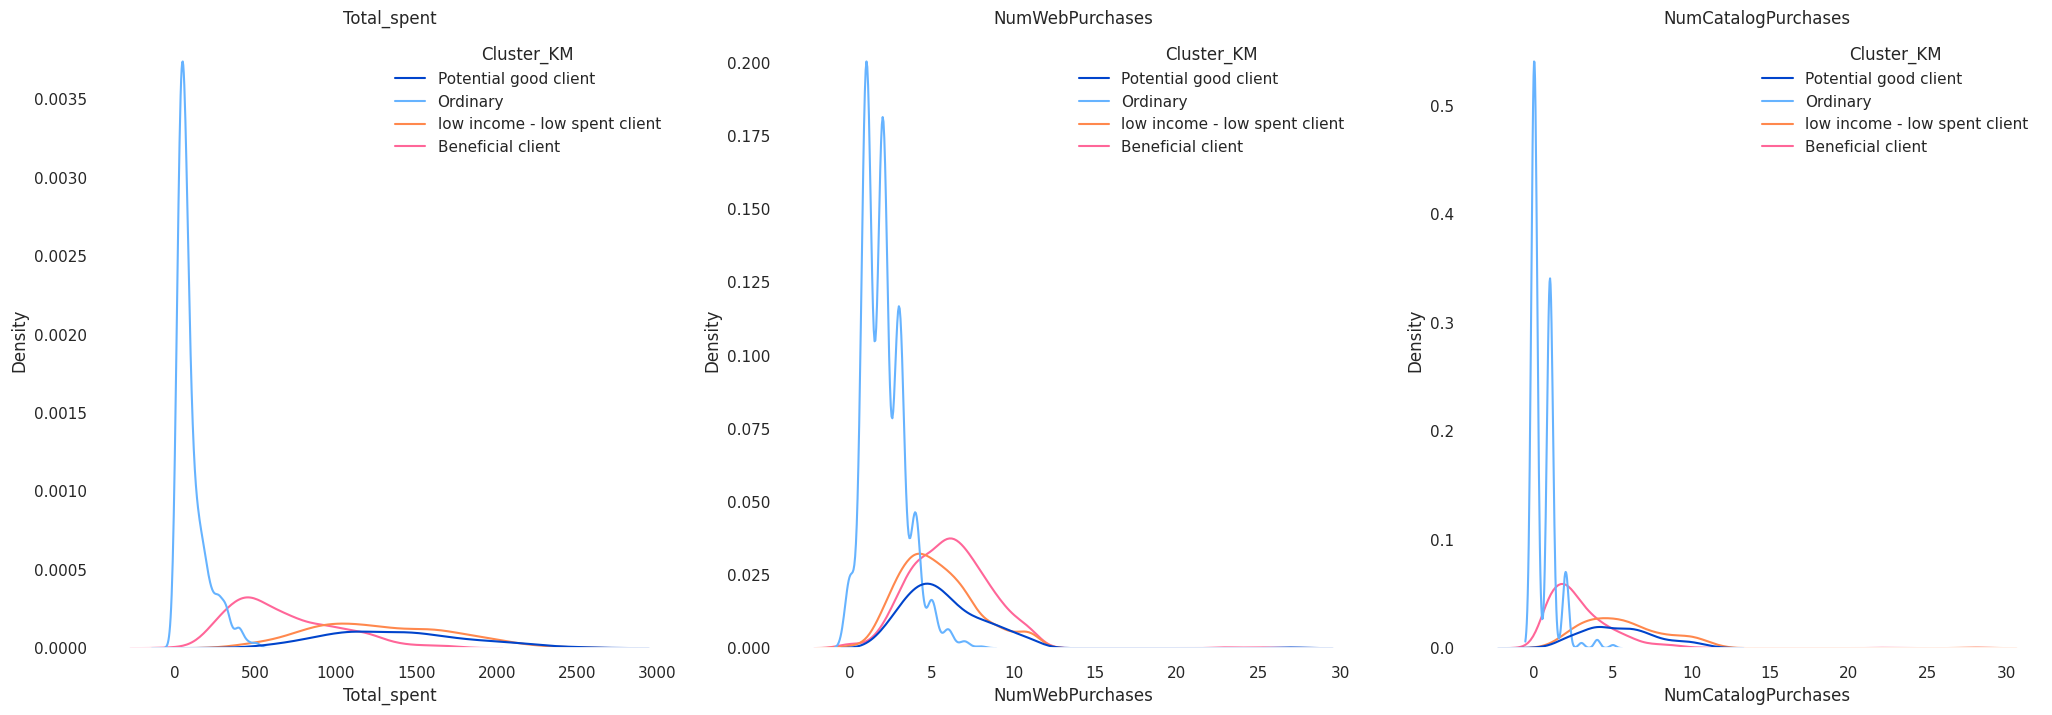

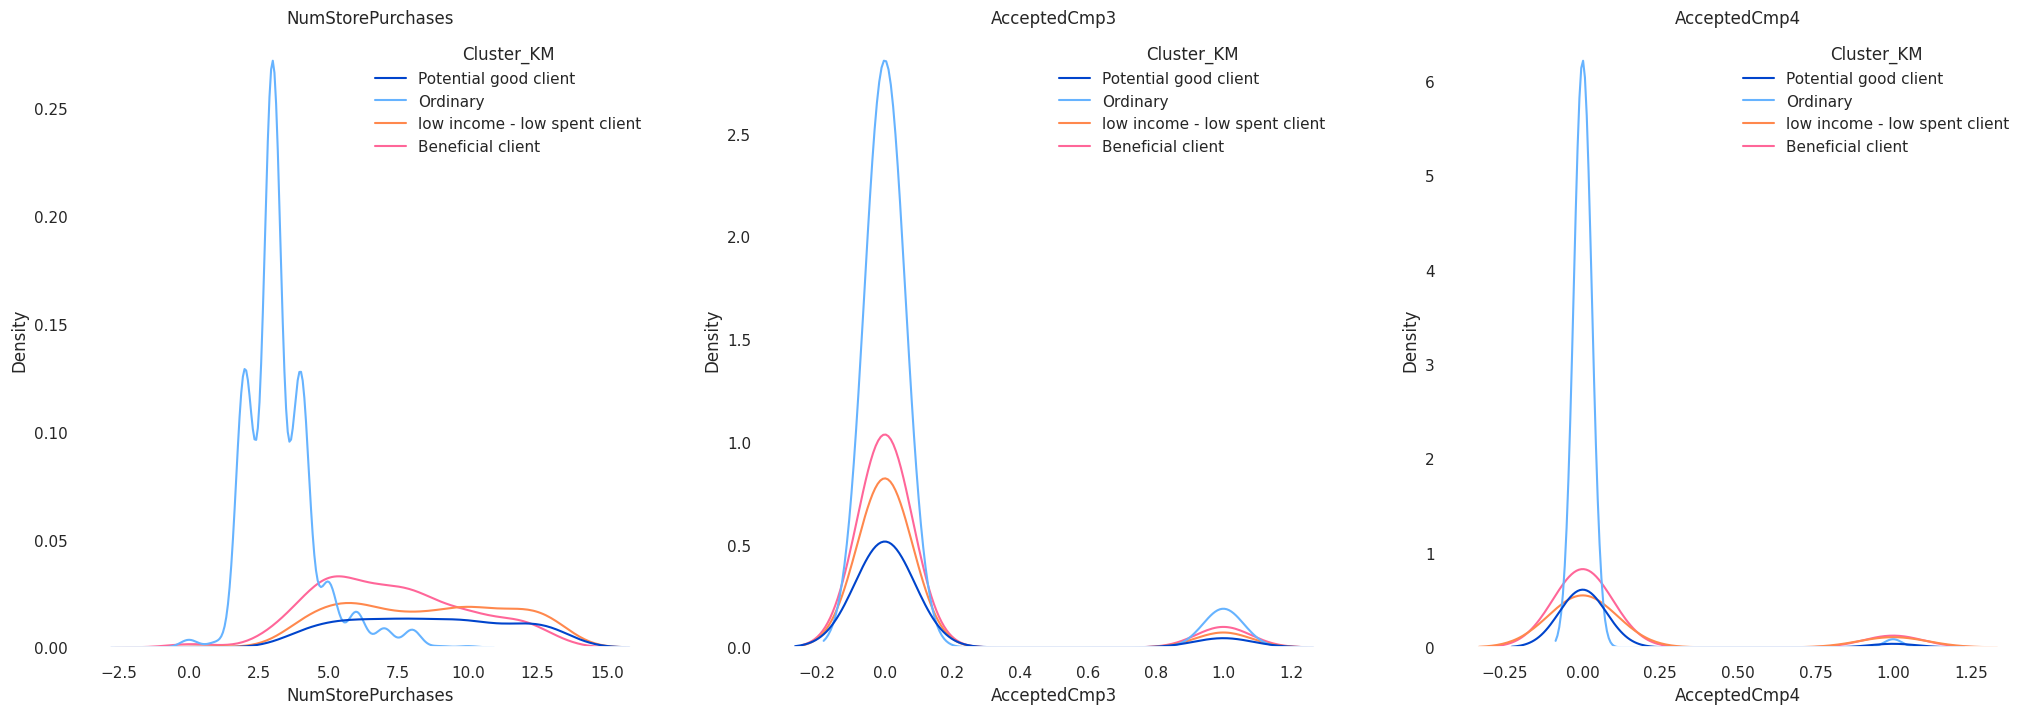

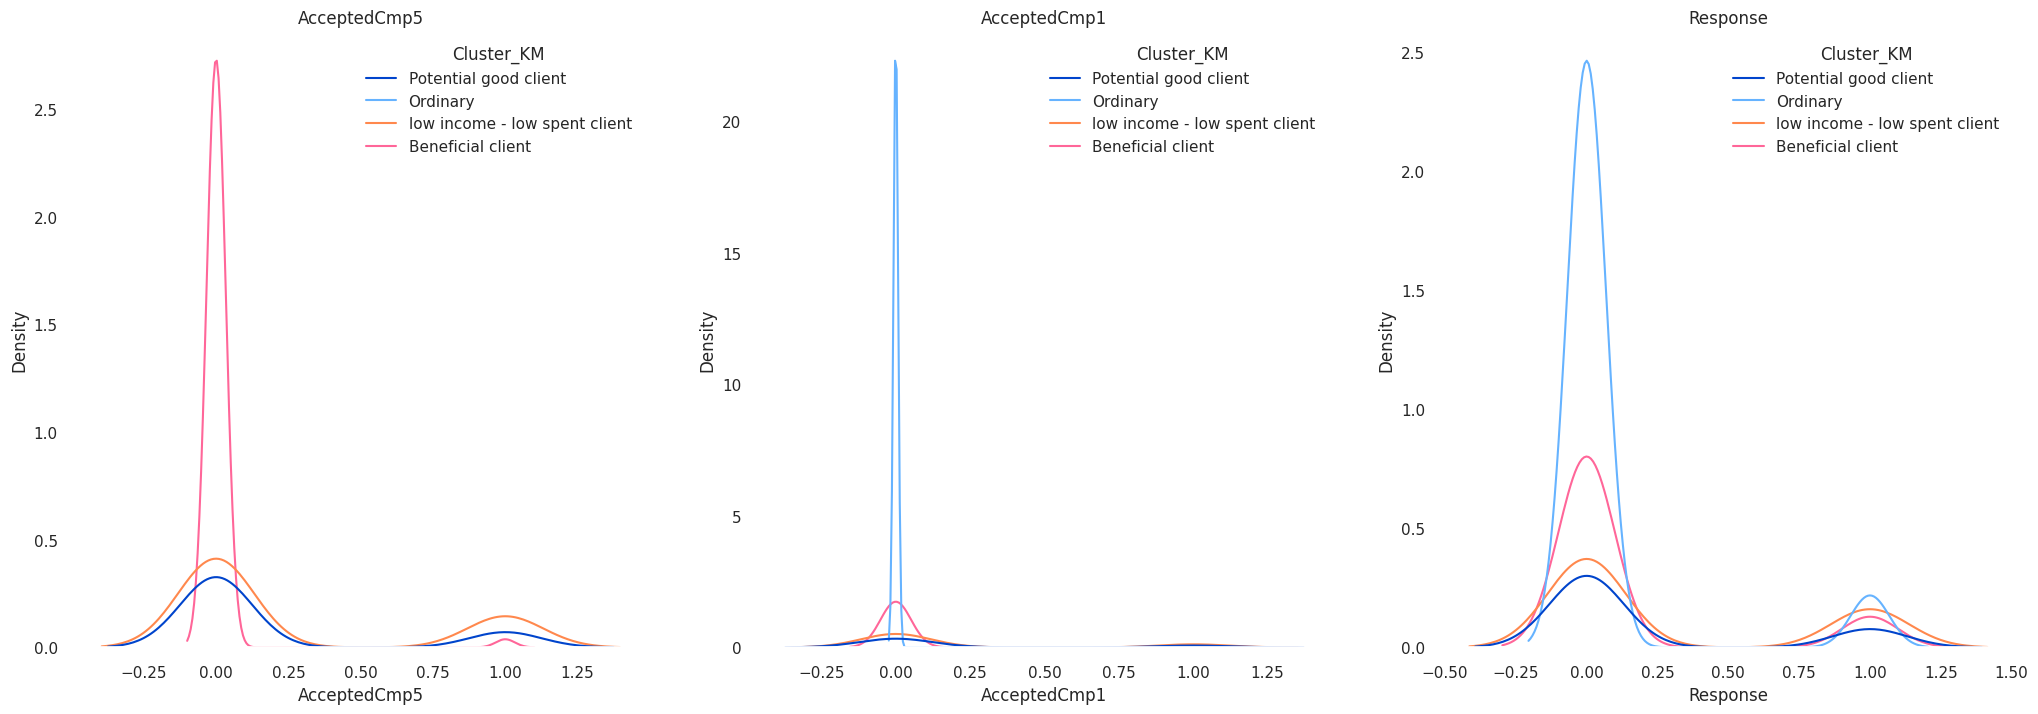

In [ ]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.grid' : True, 'font.family': 'DejaVu Sans'})

behavior = ['Total_spent',  'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1',  'Response']
i=0
for col in behavior:
    if i%3==0:
        fig, ax = plt.subplots(1,3)
        fig.set_size_inches(25,8)
    sns.kdeplot(data=df4, x=col, hue="Cluster_KM",ax=ax[i%3],palette=palette)
    ax[i%3].set_title(col)
    i+=1


/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

80.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

83.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3544: UserWarning:

27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



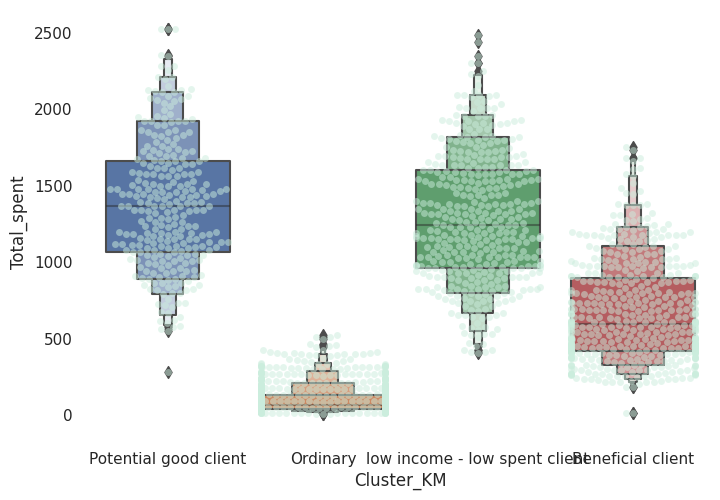

In [ ]:
plt.figure()
pl=sns.swarmplot(x=df4["Cluster_KM"], y=df4["Total_spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df4["Cluster_KM"], y=df4["Total_spent"])
plt.show()

In [ ]:
categorical_columns = ["Education", "Marital_Status",
                       "Complain"]
features_df = pd.get_dummies(df4, columns=categorical_columns)

In [ ]:
numerical_columns = ["Recency", "NumWebVisitsMonth", "Income",
                     "MntWines", "MntFruits",
                     "MntMeatProducts", "MntFishProducts",
                     "MntSweetProducts", "MntGoldProds",
                     "NumTotalPurchases", "Age","Household_size"]
sc = StandardScaler()
for i in range(len(numerical_columns)):
  features_df[numerical_columns[i]] = sc.fit_transform(features_df[[numerical_columns[i]]])

In [ ]:
features_df.head()

Age    Income   Recency  MntWines  MntFruits  MntMeatProducts  \
0  0.986443  0.311661  0.310532  0.978226   1.549429         1.690227   
1  1.236801 -0.259470 -0.380509 -0.872024  -0.637328        -0.717986   
2  0.318822  0.964196 -0.795134  0.358511   0.569159        -0.178368   
3 -1.266777 -1.213358 -0.795134 -0.872024  -0.561922        -0.655551   
4 -1.016420  0.319167  1.554407 -0.391671   0.418348        -0.218505   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  ...  \
0         2.454568          1.484827      0.850031                  3  ...   
1        -0.651038         -0.633880     -0.732867                  2  ...   
2         1.340203         -0.146821     -0.037937                  1  ...   
3        -0.504892         -0.585174     -0.752171                  2  ...   
4         0.152766         -0.000703     -0.559135                  5  ...   

                      Cluster_KM  Clusters_hi  Education_Graduate  \
0          Potential good client            1                   1   
1                       Ordinary            2                   1   
2  low income - low spent client            0                   1   
3                       Ordinary            2                   1   
4              Beneficial client            0                   0   

   Education_Postgraduate  Education_Undergraduate  Marital_Status_  \
0                       0                        0                0   
1                       0                        0                0   
2                       0                        0                0   
3                       0                        0                0   
4                       1                        0                0   

   Marital_Status_Partner  Marital_Status_Single  Complain_0  Complain_1  
0                       0                      1           1           0  
1                       0                      1           1           0  
2                       1                      0           1           0  
3                       1                      0           1           0  
4                       1                      0           1           0  

[5 rows x 39 columns]

In [ ]:
corr_matrix = features_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
features_df =  features_df.drop(to_drop, axis=1)
features_df.shape

<ipython-input-126-0871fb61d023>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-126-0871fb61d023>:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



(2216, 35)

# 6. Calculating RFM Metrics

In [ ]:
rfm = pd.DataFrame()
rfm["customer_id"] = df["ID"]
rfm["recency"] = df["Recency"]
rfm["frequency"] = df["Num_Total_Purchases"]
rfm["monetary"] = df["Total_Spent"]

rfm.head()


KeyError: ignored

In [ ]:
#Calculating RF and RFM Scores Converting Recency, Frequency, and Monetary metrics to scores between 1-5 with the help of qcut and recording these scores as recency_score, frequency_score, and monetary_score then expressing recency_score and frequency_score as a single variable and saving it as RF_SCORE.
# recency_score, frequency_score, monetary_score

rfm["recency_score"] = pd.qcut(rfm['recency'].rank(method="first"), 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# RF_SCORE

rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))

rfm.head()

# 6.1 Definition of RF Scores as Segments

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)
rfm.head()

In [ ]:
# Visualized to see percentages of segments

rfm["segment"].value_counts().plot.pie(subplots=True, autopct='%1.1f%%', explode=[0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3])
plt.show()

# 6.2 CLTV Modelling

In [ ]:
df_c = df # Saving df as df_c to restore if data gets corrupted during operations.
df_c["Dt_Customer"] = df_c["Dt_Customer"].apply(pd.to_datetime) # Converting date variable's datatype to datetime.

# Recency: The age of the customer when he made its last purchase (Last customer purchase date - first customer purchase date)
# T: Customer's age. (how long before the analysis date the first purchase was made)
# Frequency: The number of repeated purchases the customer made after his first date of first purchase
# Average Monetary: The average amount spent by a customer

cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df_c["ID"]
cltv_df["recency_cltv_weekly"] = df_c["Recency"] /7  # Expression of recency and T for BGNBD in weekly terms
cltv_df["T_weekly"] = ((df['Dt_Customer'].max() - df['Dt_Customer']).dt.days / 7 ) + 20
cltv_df["frequency"] = df_c["order_num_total"]
cltv_df["monetary_cltv_avg"] = df_c["customer_value_total"] / df_c["order_num_total"] # Expressing monetary value as average earnings per purchase

cltv_df.head()

# 6.3 Preparation of BG/NBD and Gamma-Gamma Models, calculation of 6-month CLTV

In [ ]:
# 1. Preparation of the BGNBD model

bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

# Estimate expected purchases from customers in 3 months and add exp_sales_3_month to cltv dataframe.

cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

# Estimate expected purchases from customers in 6 months and add exp_sales_6_month to cltv dataframe.

cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

# 2.  Fit the Gamma-Gamma model. Estimate the average value of the customers and add it to the cltv dataframe as exp_average_value.

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])
cltv_df.head()

# 3. Calculate 6 months CLTV and add it to the dataframe with the name cltv.

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)
cltv_df["cltv"] = cltv

# 6.4 Creating Segments by CLTV

In [ ]:
# 1. Divide all your customers into 4 groups (segments) according to 6-month CLTV and add the group names to the dataset. Assign it with the name cltv_segment.

cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df = cltv_df.sort_values(by="cltv", ascending=False)
cltv_df.reset_index(inplace=True, drop=True)
cltv_df.head(10)

In [ ]:
cltv_final = cltv_df.merge(rfm, on="customer_id", how="left")
cltv_final.head()

In [ ]:
# Group df by segment and check the mean and total values of the variables.

cltv_final[["segment", "recency_cltv_weekly","frequency_x","T_weekly","monetary_cltv_avg","exp_average_value"]].groupby("segment").agg(
    {"count", "mean"})

In [ ]:
cltv_final[["segment", "cltv"]].groupby("segment").agg({"count"})

# 7. Income prediction

In [ ]:
Y = features_df["Income"]
X = features_df.drop("Income", axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [ ]:
DTC_Regressor = DecisionTreeRegressor()
DTC_params= {"criterion":["squared_error"], "min_samples_split": [2, 3, 4], "min_samples_leaf": [1, 2, 4], "max_depth": [None, 3, 5]}
DTC_grid_cv = GridSearchCV(DTC_Regressor, param_grid=DTC_params, cv=4)
DTC_grid_cv.fit(X_train, Y_train)
print("Decision Tree")
print("")
print("Best Params : ", DTC_grid_cv.best_params_)
print("Best Scores          : ", DTC_grid_cv.best_score_)

xgb_Regressor = XGBRegressor()
xgb_params= {"min_child_weight": [1, 5, 10], "max_depth": [3,4], "colsample_bytree": [0.6, 1.0], "learning_rate":[0.1, 0.3], "n_jobs": [-1], "objective":['reg:squarederror'], }
xgb_grid_cv = GridSearchCV(xgb_Regressor, param_grid=xgb_params, cv=4)
xgb_grid_cv.fit(X_train, Y_train)
print("")
print("")
print("XGBOOST")
print("")
print("Best Params : ", xgb_grid_cv.best_params_)
print("Best Scores          : ", xgb_grid_cv.best_score_)

rf_Regressor = RandomForestRegressor()
rf_params= {"n_estimators":[70, 100, 130], "min_samples_leaf": [1, 2, 4], "min_samples_split": [2, 5, 10], "n_jobs": [-1]}
rf_grid_cv = GridSearchCV(rf_Regressor, param_grid=rf_params, cv=4)
rf_grid_cv.fit(X_train, Y_train)
print("")
print("")
print("Random Forest")
print("")
print("Best Params : ", rf_grid_cv.best_params_)
print("Best Scores         : ", rf_grid_cv.best_score_)

KNN_Regressor = KNeighborsRegressor()
KNN_params= {"n_neighbors":[3,4,5,6,7], "n_jobs": [-1], "weights":["uniform", "distance"]}
KNN_grid_cv = GridSearchCV(KNN_Regressor, param_grid=KNN_params, cv=4)
KNN_grid_cv.fit(X_train, Y_train)
print("")
print("")
print("KNN")
print("")
print("Best Params : ", KNN_grid_cv.best_params_)
print("Best Scores         : ", KNN_grid_cv.best_score_)


In [ ]:
xgb_r = XGBRegressor( learning_rate=0.1, max_depth=4, colsample_bytree=1.0, min_child_weight=5, silent=0, gpu_id=0, objective="reg:squarederror")
xgb_r.fit(X_train, Y_train)
xgb.plot_importance(xgb_r,max_num_features=30)

In [ ]:
xgb_r = XGBRegressor(learning_rate=0.1, max_depth=4, colsample_bytree=1.0, min_child_weight=5, silent=0, gpu_id=0, objective="reg:squarederror")
xgb_r.fit(X_train, Y_train)

knn = KNeighborsRegressor(n_neighbors=7, weights="distance")
knn.fit(X_train, Y_train)

dec_tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=2, criterion="squared_error")
dec_tree.fit(X_train, Y_train)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, min_samples_split=2)
rf.fit(X_train, Y_train)


In [ ]:
models = []
models.append(('XGBOOST', xgb_r))
models.append(("KNN", knn))
models.append(("Decision Tree", dec_tree))
models.append(("Random Forest", rf))

for i, v in models:

    prediction_train = v.predict(X_train)

    print(f"----------------------------- {i} Model Evaluation -----------------------------")
    print("Training Set CV R-Square value    : {}".format(cross_val_score(v, X_train, Y_train, cv=4).mean()))
    print("Mean Absolute Error (MAE)        : {}".format(mean_absolute_error(Y_train, prediction_train)))
    print("Mean Square Error (MSE)          : {}".format(mse(Y_train, prediction_train)))
    print("Root Mean Square Error (RMSE)     : {}".format(rmse(Y_train, prediction_train)))
    print("Mean Absolute Percentage Error (MAPE) : {}".format(np.mean(np.abs((Y_train - prediction_train) / Y_train)) * 100))


In [ ]:
models = []
models.append(('XGBOOST', xgb_r))
models.append(("KNN", knn))
models.append(("Decision Tree", dec_tree))
models.append(("Random Forest", rf))

for i, v in models:

    prediction_test = v.predict(X_test)

    print(f"----------------------------- {i} Model Test Results -----------------------------")
    print("Test Set CV R-Square value         : {}".format(v.score(X_test, Y_test)))
    print("Mean Absolute Error (MAE)        : {}".format(mean_absolute_error(Y_test, prediction_test)))
    print("Mean Square Error (MSE)          : {}".format(mse(Y_test, prediction_test)))
    print("Root Mean Square Error (RMSE)     : {}".format(rmse(Y_test, prediction_test)))
    print("Mean Absolute Percentage Error (MAPE) : {}".format(np.mean(np.abs((Y_test - prediction_test) / Y_test)) * 100))
